In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

In [3]:
import pandas as pd
from nltk.stem import *
from nltk.corpus import stopwords
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import time
import sklearn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, cohen_kappa_score,make_scorer
import pickle

In [4]:
df = pd.read_excel('iphproductdata2_9.xlsx')
df.head()

Country Code         IPH Category IPH Sub Category  \
0           AT  General Merchandise        Batteries   
1           AT  General Merchandise        Batteries   
2           AT  General Merchandise        Batteries   
3           AT  General Merchandise        Batteries   
4           AT  General Merchandise        Batteries   

                                        Product  \
0  LL Altartikel Varta longlife Mono D 1,5V 1St   
1          Varta Electronics CR2016 Blister 2St   
2                   Varta Knopfzelle CR2025 2St   
3                Varta longlife Mono D 1,5V 1St   
4          Varta Longlife Power 9V Blister 10St   

                     Product Description Product Code  Gross Sales USD  
0     OL: Varta longlife Mono D 1.5V 1st       100832        1708.0190  
1   Varta Electronics CR2016 Blister 2pc       116270         391.2206  
2          OL: Varta Erlectronics CR2025       110202        2789.4703  
3     OL: Varta longlife Mono D 1.5V 1st       100832        1819.7663  
4  Varta Longlife Power 9V Blister 10pcs       100836         111.1617

In [5]:
df.isna().sum()

Country Code              0
IPH Category              0
IPH Sub Category          0
Product                   0
Product Description       0
Product Code              0
Gross Sales USD        1070
dtype: int64

In [6]:
df = df.drop(index=df[df.duplicated(['Product Description'])].index) 

In [7]:
df['Final_Category'] = df['IPH Category'].str.cat(df[['IPH Sub Category']].values,sep=' - ')

In [8]:
df['Final_Category'].head()

0    General Merchandise - Batteries
1    General Merchandise - Batteries
2    General Merchandise - Batteries
4    General Merchandise - Batteries
6    General Merchandise - Batteries
Name: Final_Category, dtype: object

In [9]:
df['Final_Category'].nunique()

43

In [10]:
final_categories_counts = df['Final_Category'].value_counts().sort_values(ascending=True)

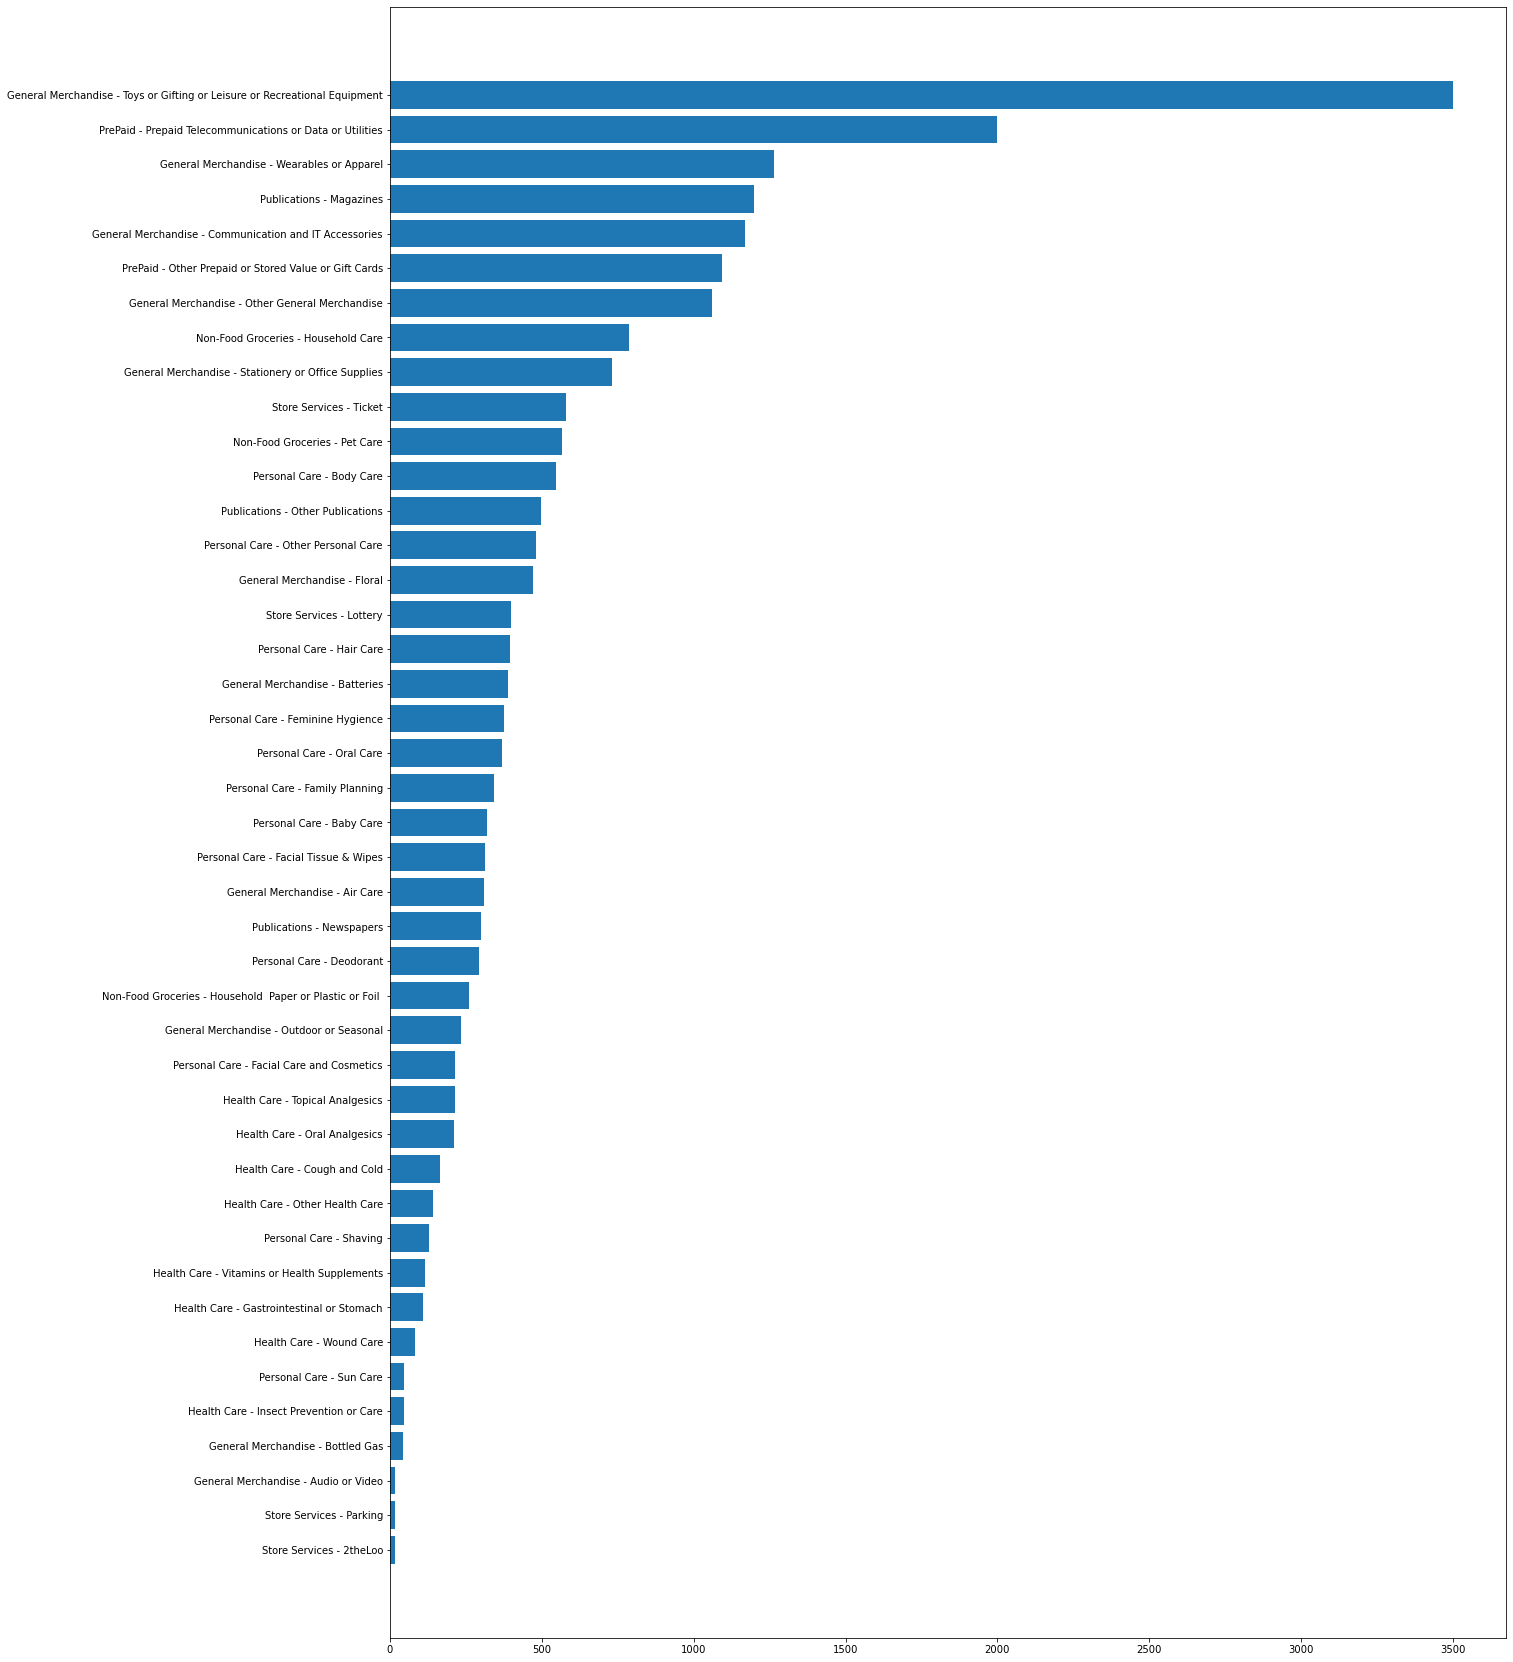

In [11]:
plt.figure(figsize=(20,30))
plt.barh(final_categories_counts.index, final_categories_counts)
plt.xlabel=None

In [12]:
final_categories_counts.head(30)

Store Services - 2theLoo                                      15
Store Services - Parking                                      17
General Merchandise - Audio or Video                          17
General Merchandise - Bottled Gas                             44
Health Care - Insect Prevention or Care                       47
Personal Care - Sun Care                                      47
Health Care - Wound Care                                      82
Health Care - Gastrointestinal or Stomach                    109
Health Care - Vitamins or Health Supplements                 114
Personal Care - Shaving                                      129
Health Care - Other Health Care                              143
Health Care - Cough and Cold                                 164
Health Care - Oral Analgesics                                211
Health Care - Topical Analgesics                             213
Personal Care - Facial Care and Cosmetics                    214
General Merchandise - Out

In [13]:
small_count_categories = final_categories_counts[final_categories_counts<=5].index

In [14]:
len(small_count_categories)

0

In [15]:
df['Final_Category'].replace(to_replace=small_count_categories, value='Other', inplace=True)

In [16]:
df['codes'] = df['Final_Category'].astype('category').cat.codes
df['codes'].nunique()

43

In [17]:
code_dictionary = dict(set(list(zip(df['codes'], df['Final_Category']))))

In [18]:
X = df['Product Description']
y = df['codes']

In [19]:
tokenizer = WhitespaceTokenizer()

In [20]:
#from wordcloud import WordCloud
#word_cloud = WordCloud(width = 1000,
                       #height = 800,
                       #colormap = 'Blues', 
                       #margin = 0,
                       #max_words = 183,  
                       #max_font_size = 120, min_font_size = 15,  
                       #background_color = "white").generate(" ".join(X_train))

#plt.figure(figsize = (10, 15))
#plt.imshow(word_cloud, interpolation = "gaussian")
#plt.axis("off")
#plt.show()

In [21]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

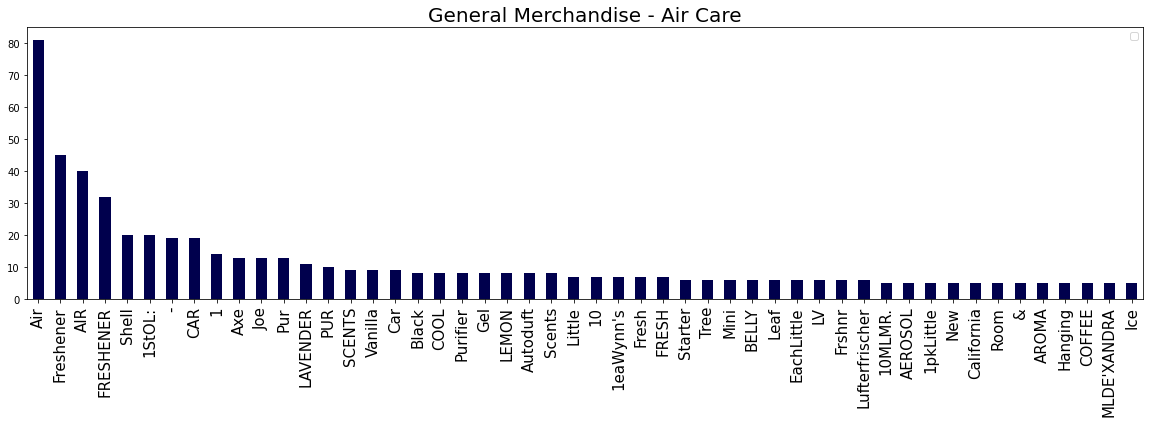

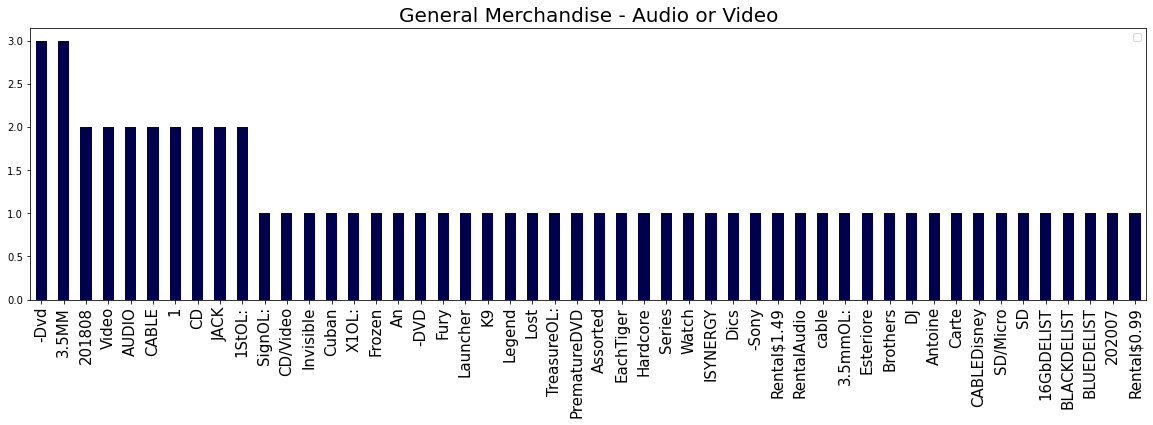

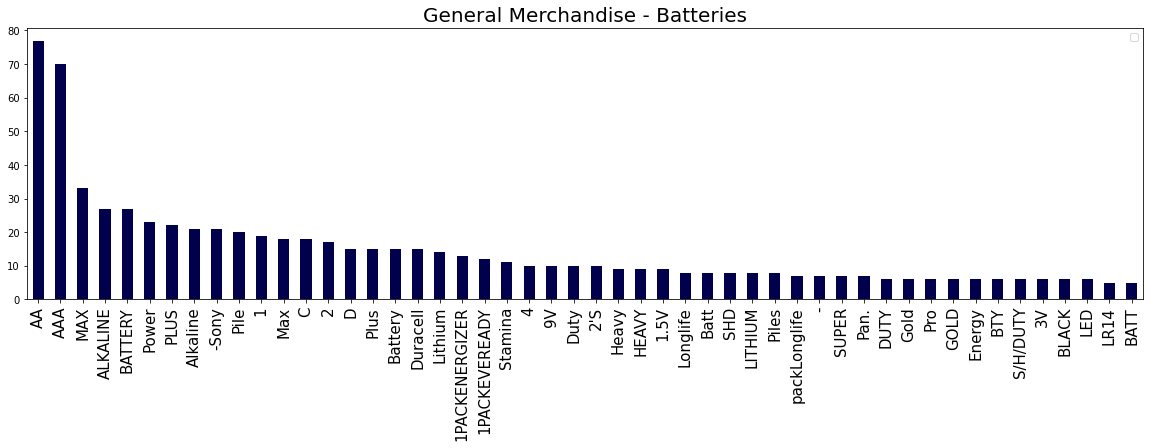

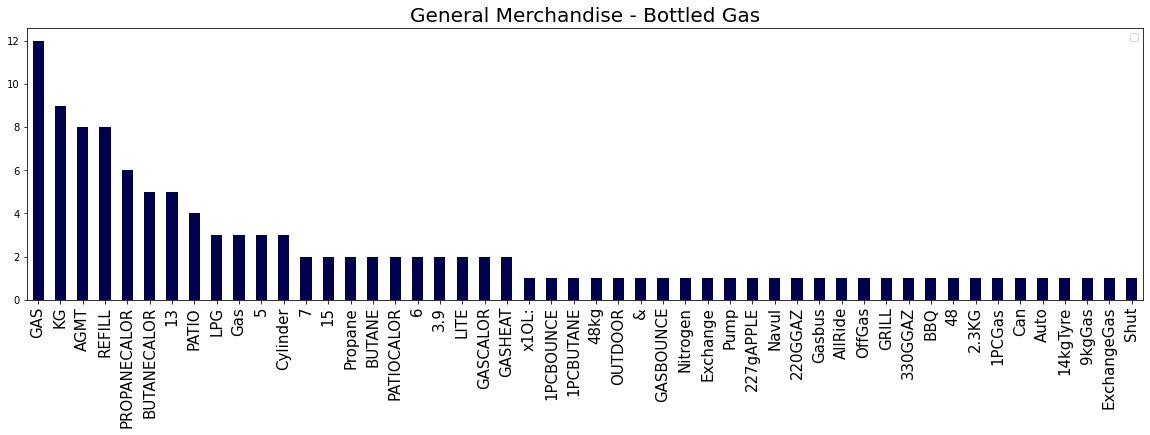

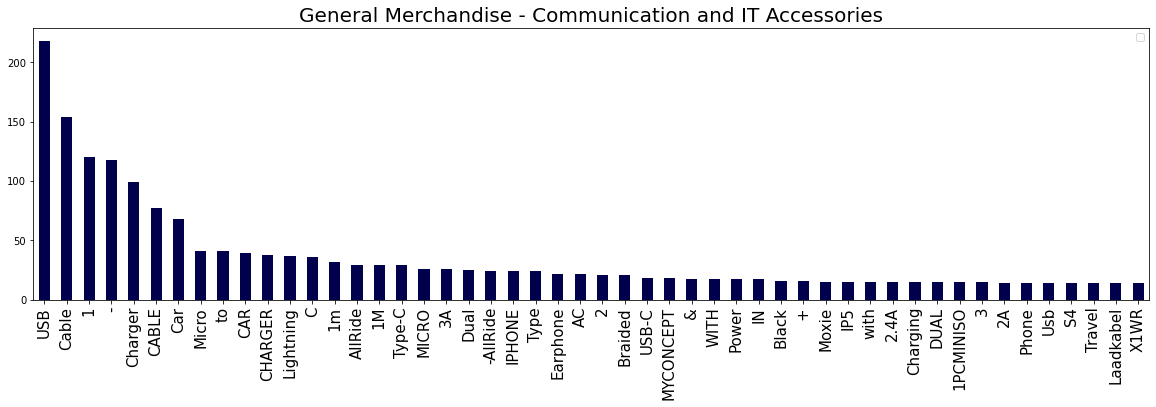

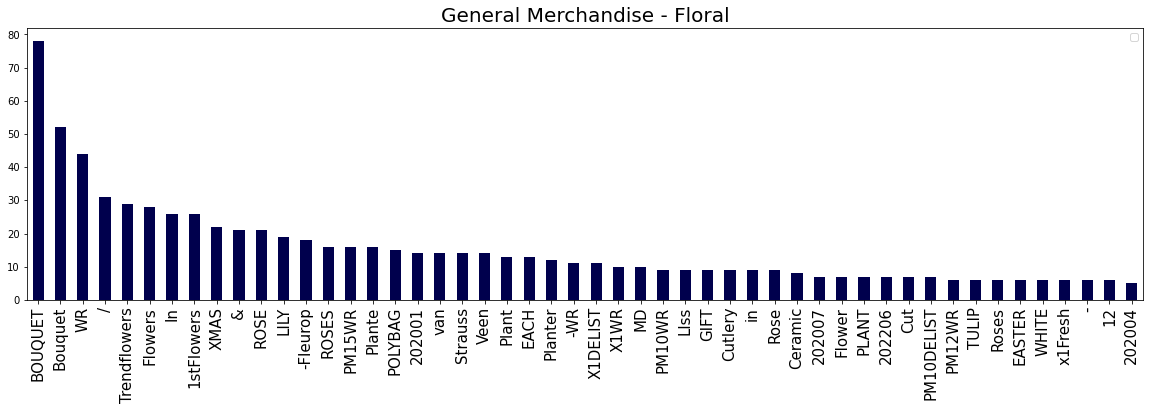

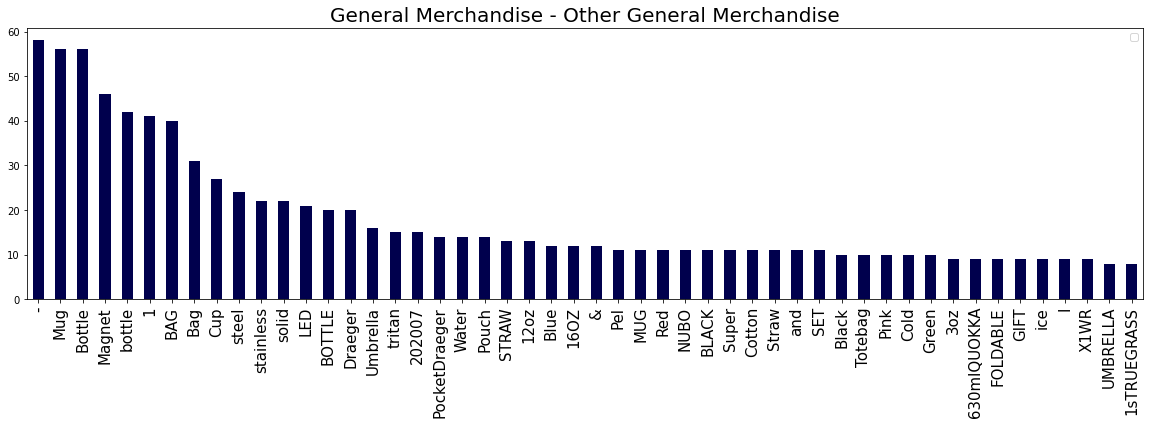

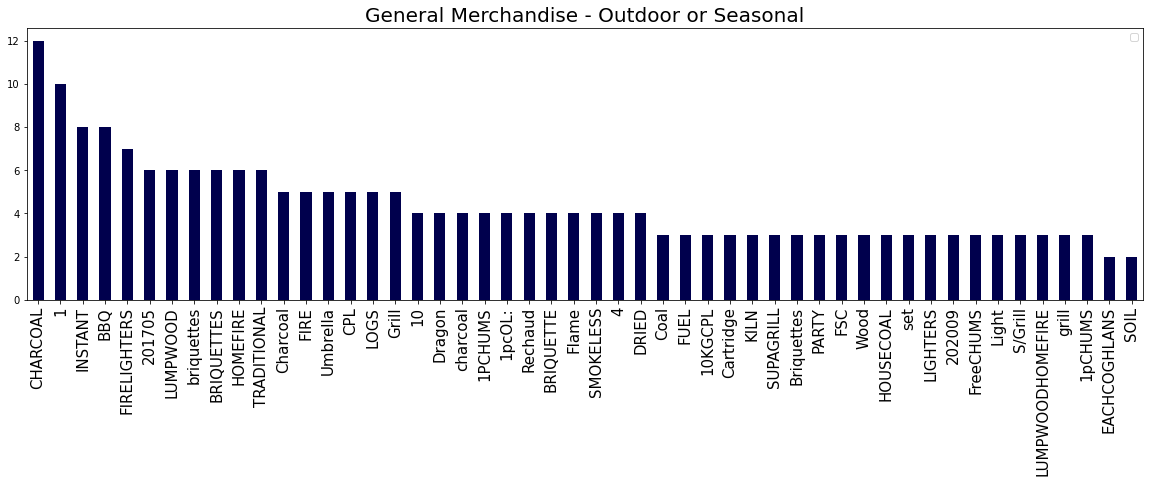

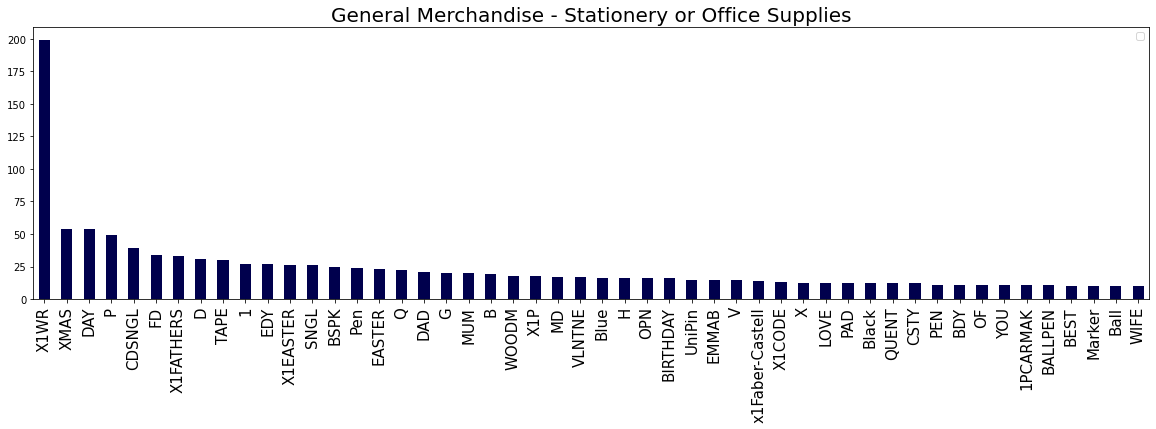

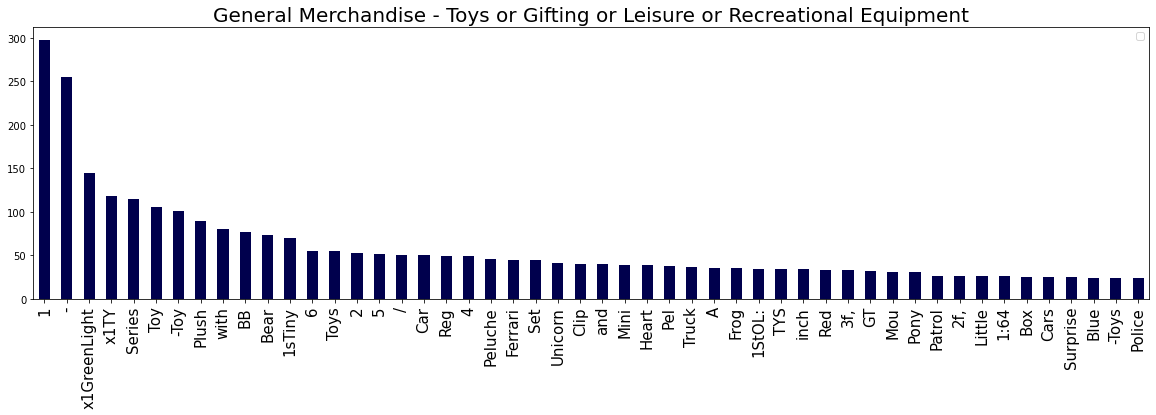

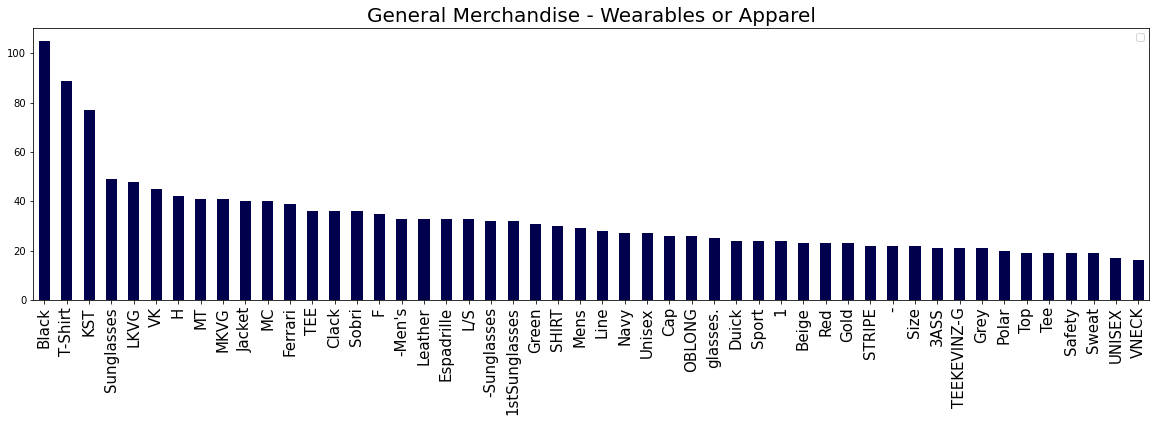

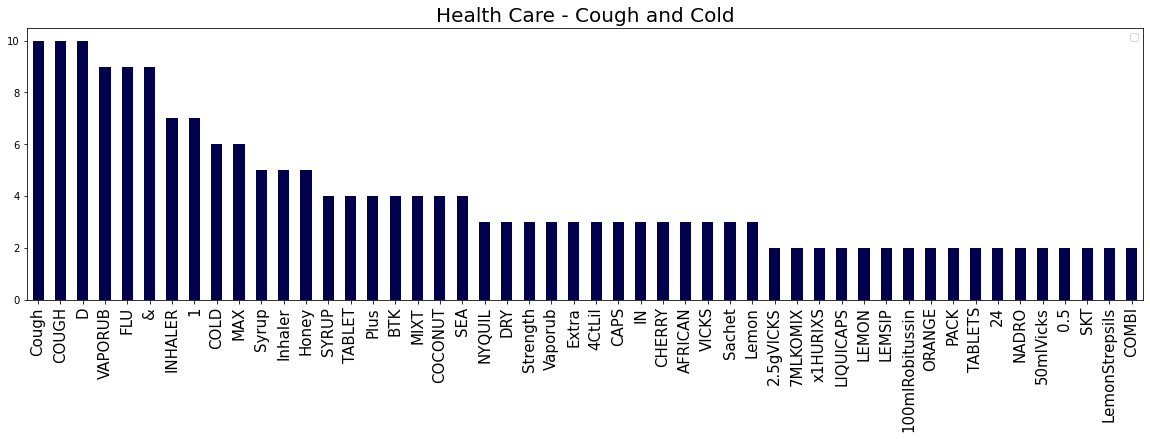

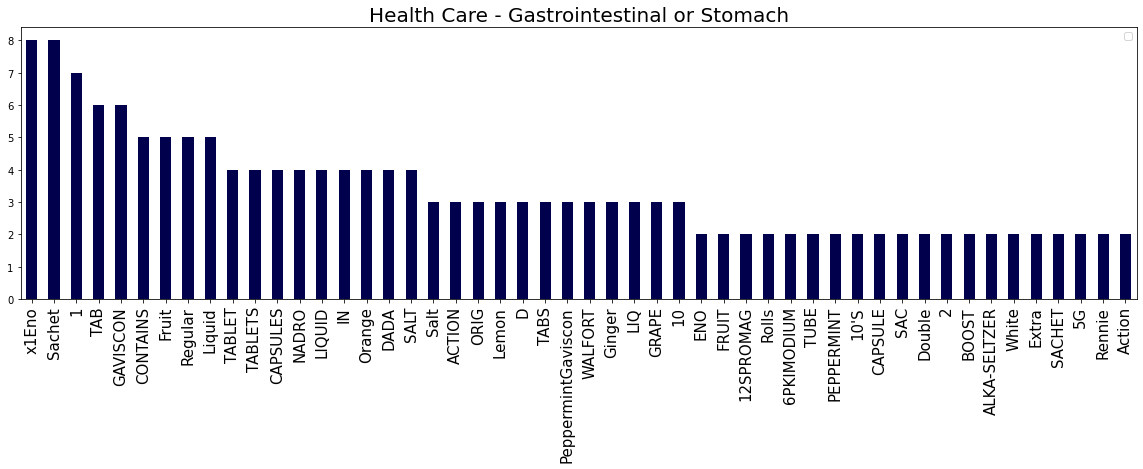

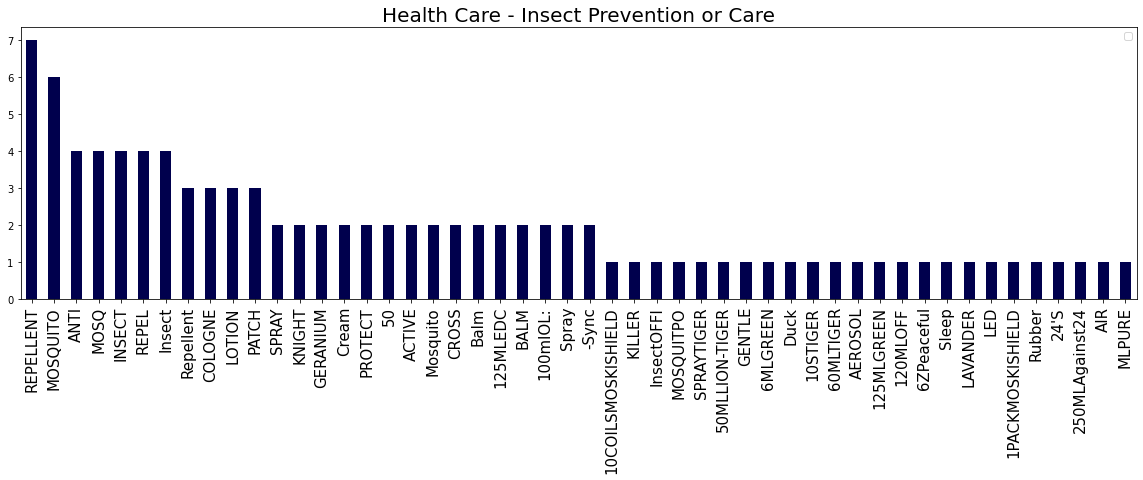

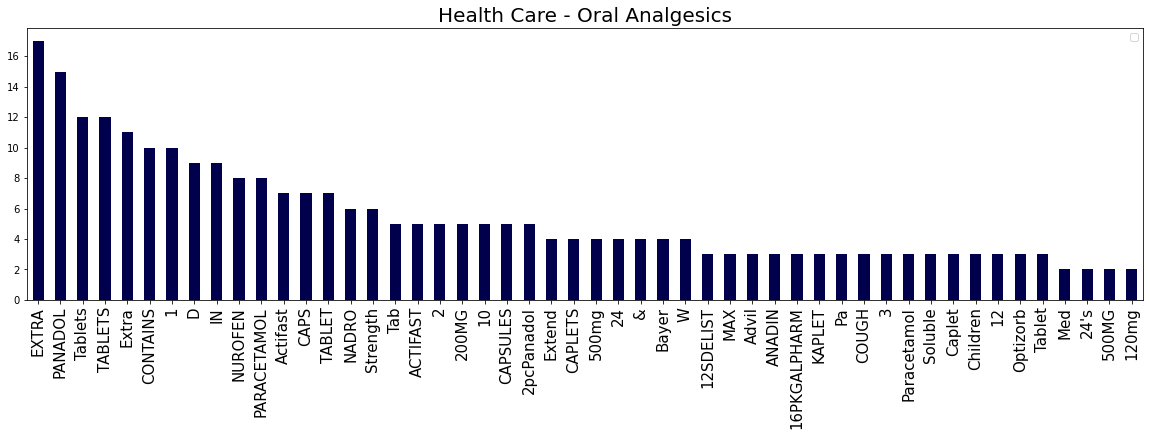

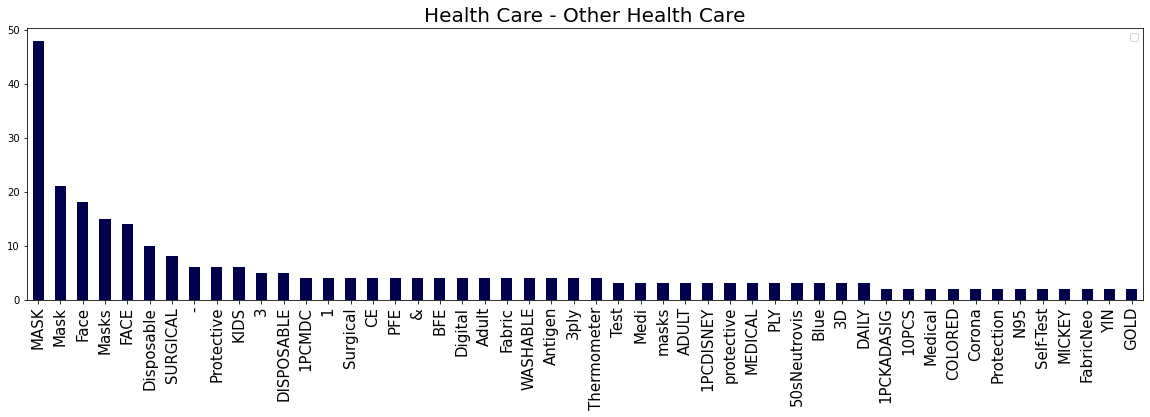

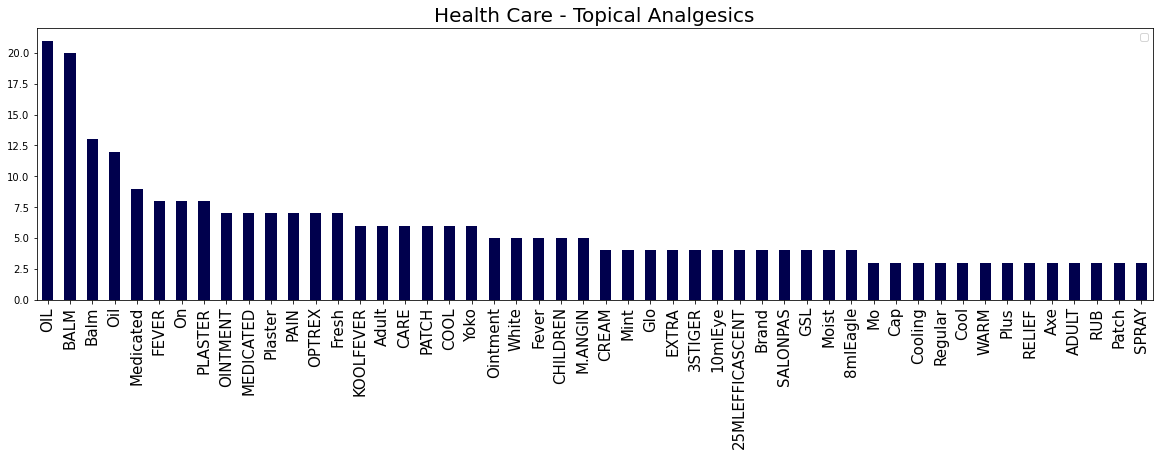

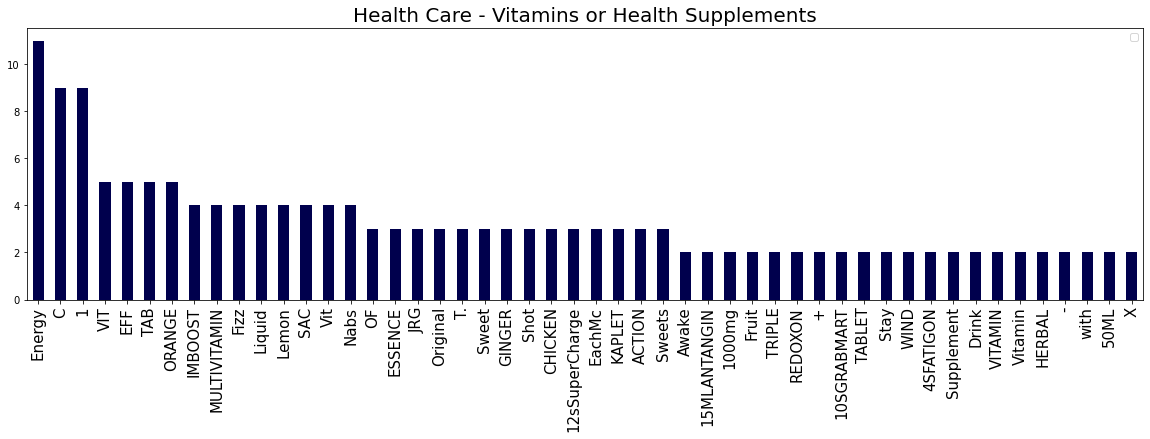

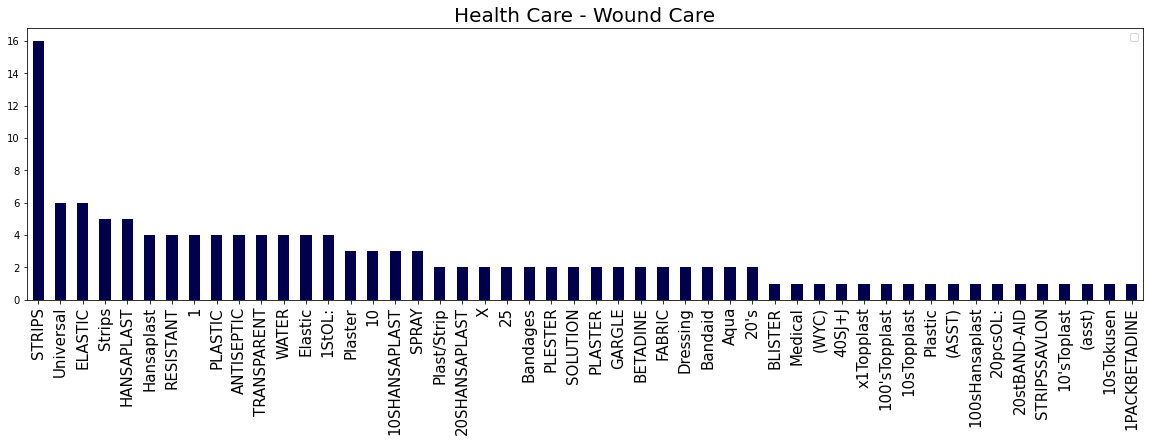

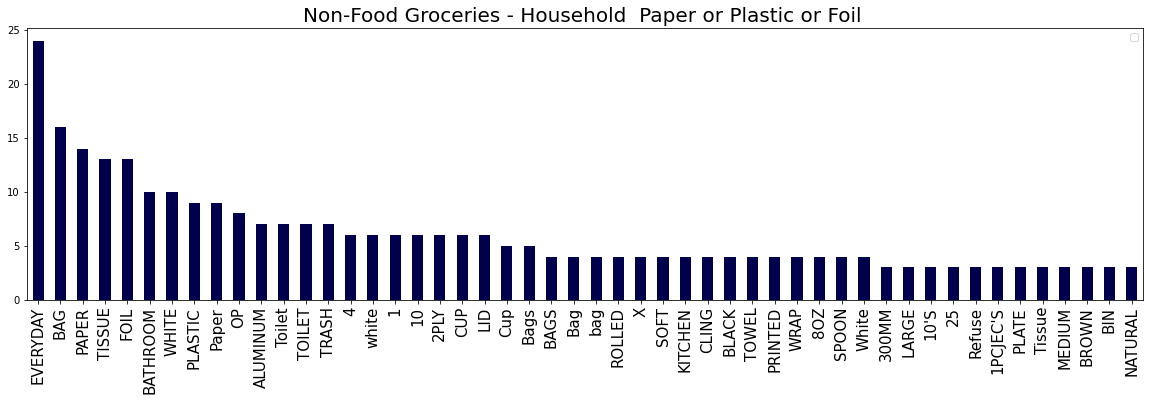

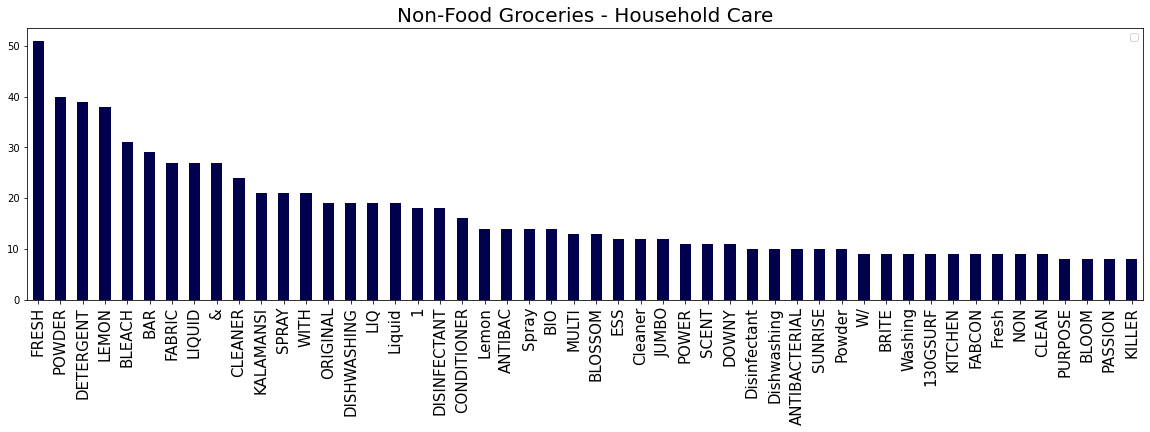

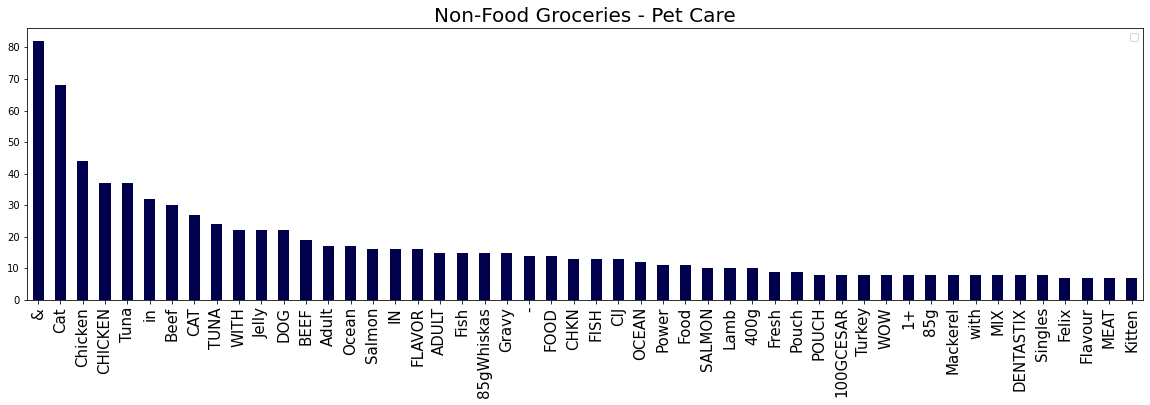

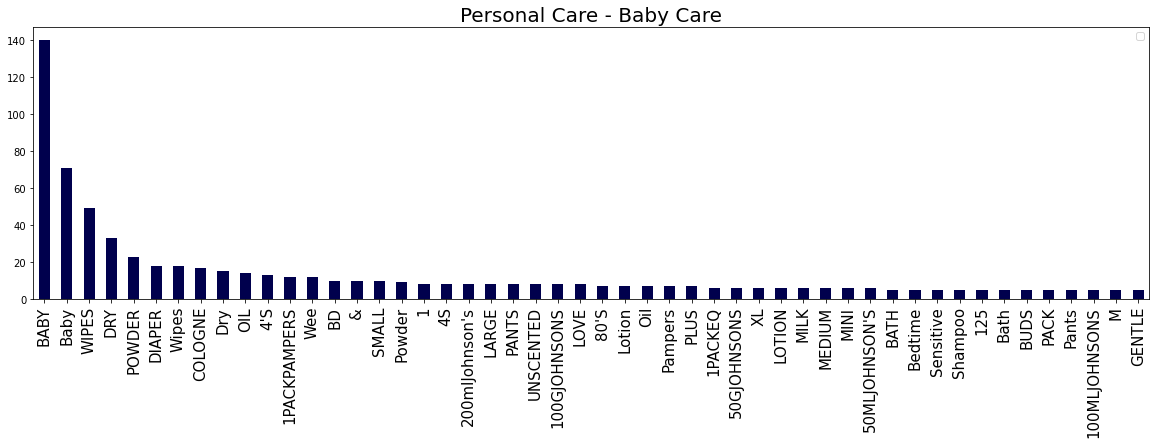

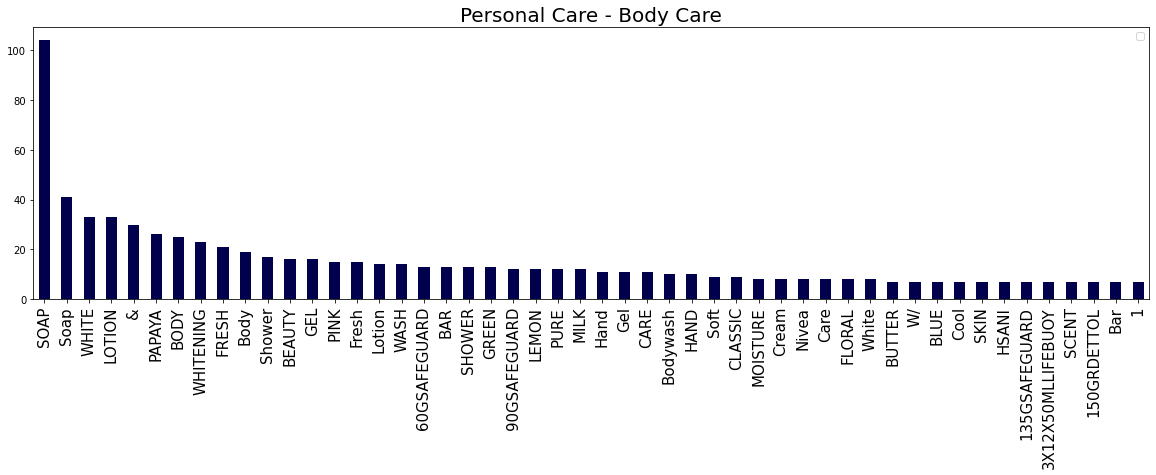

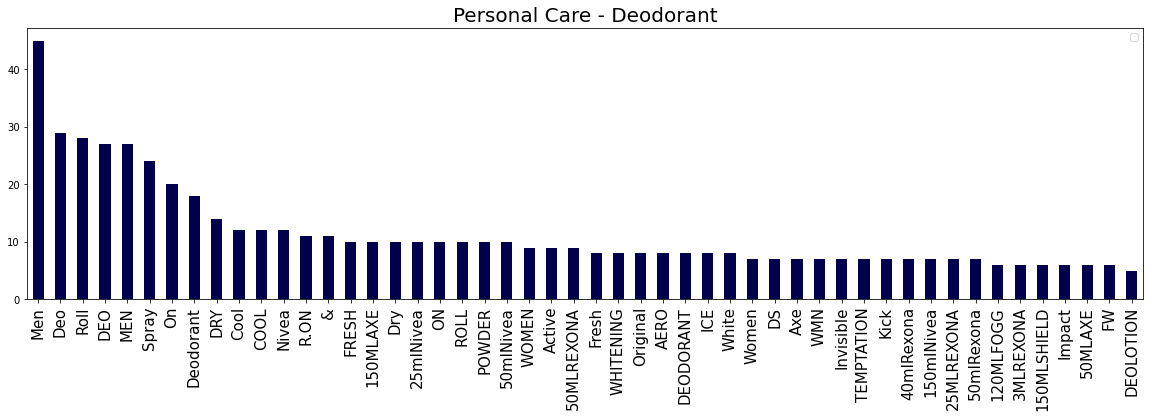

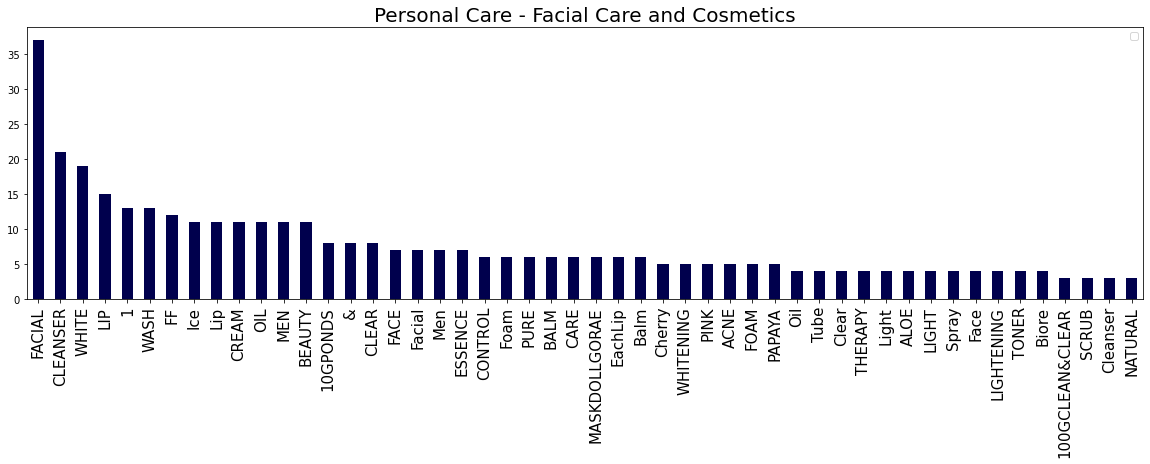

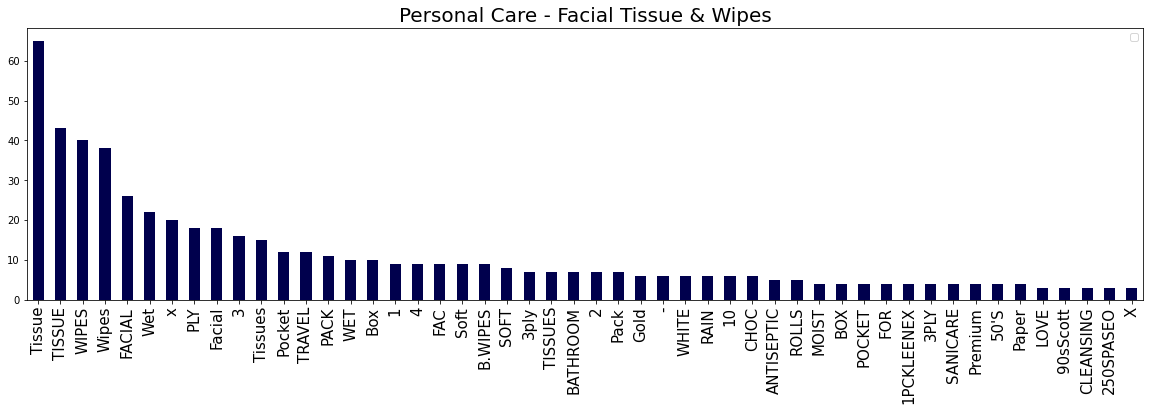

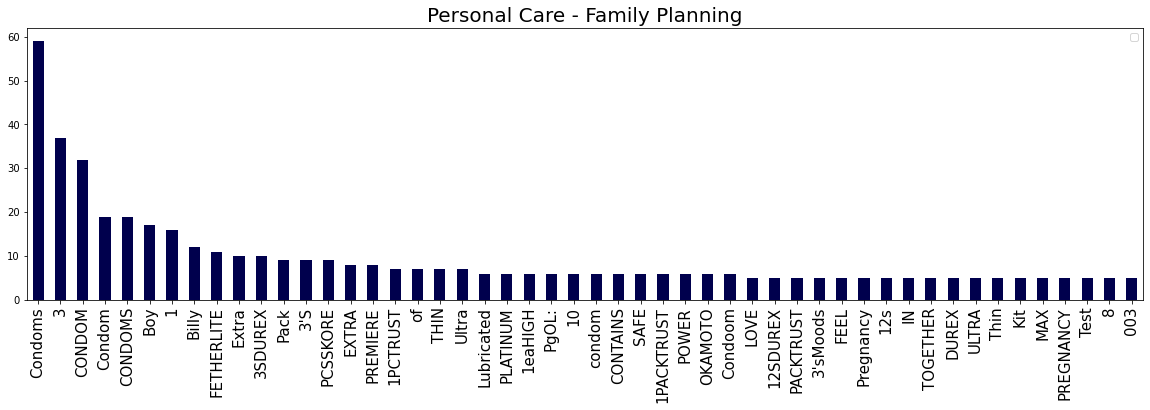

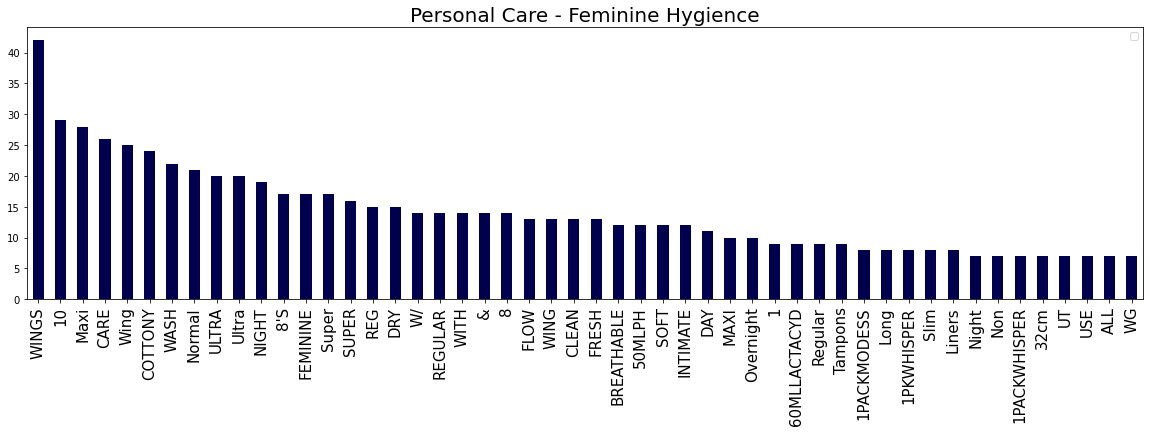

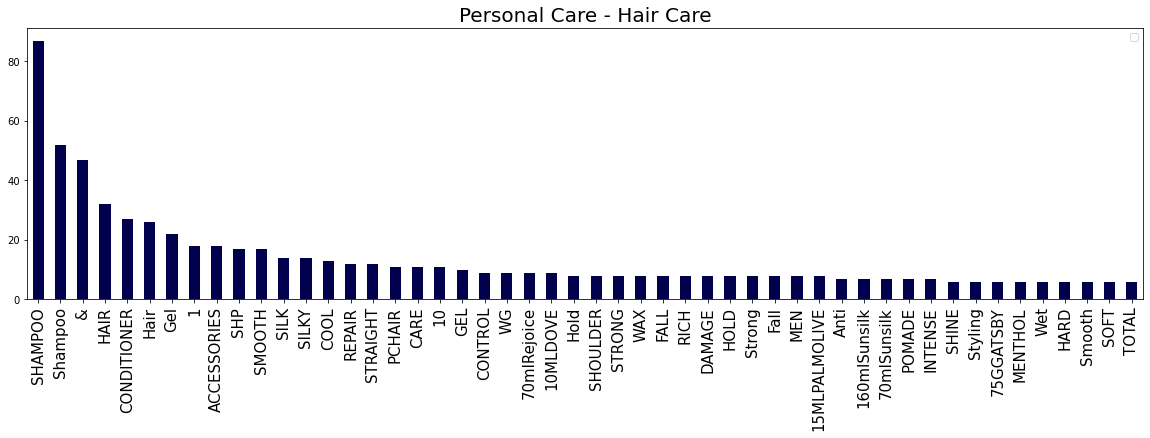

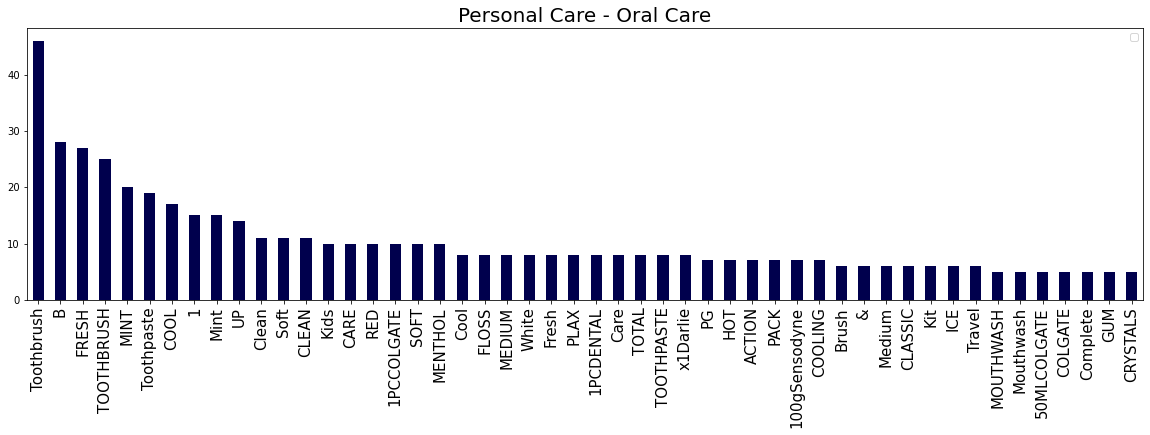

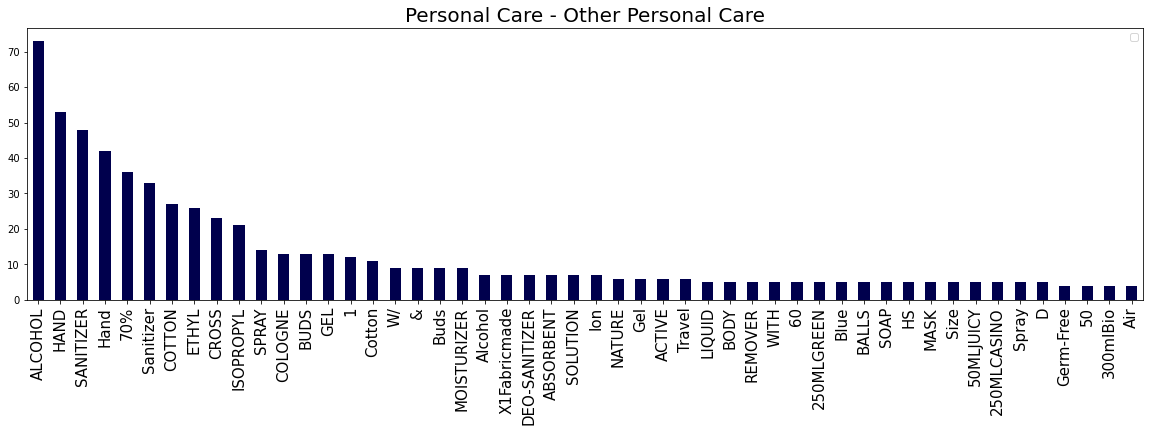

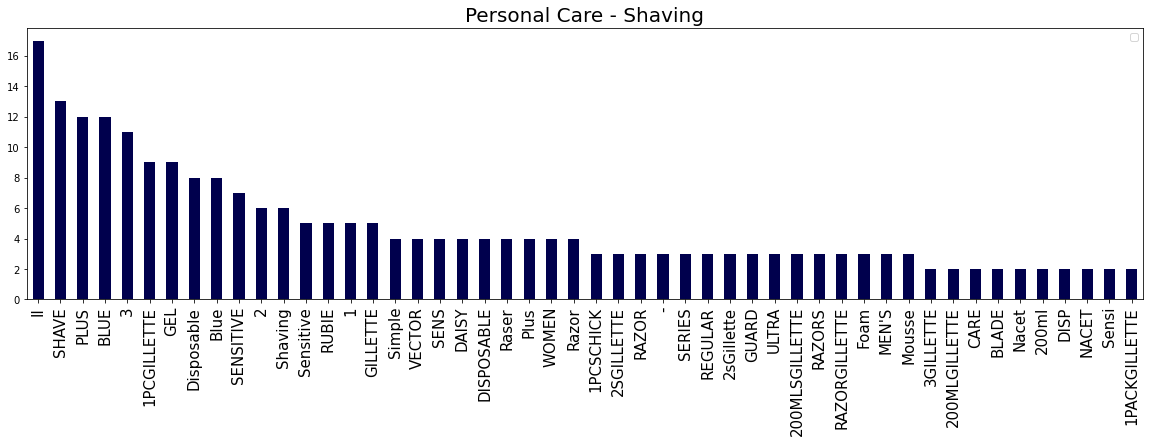

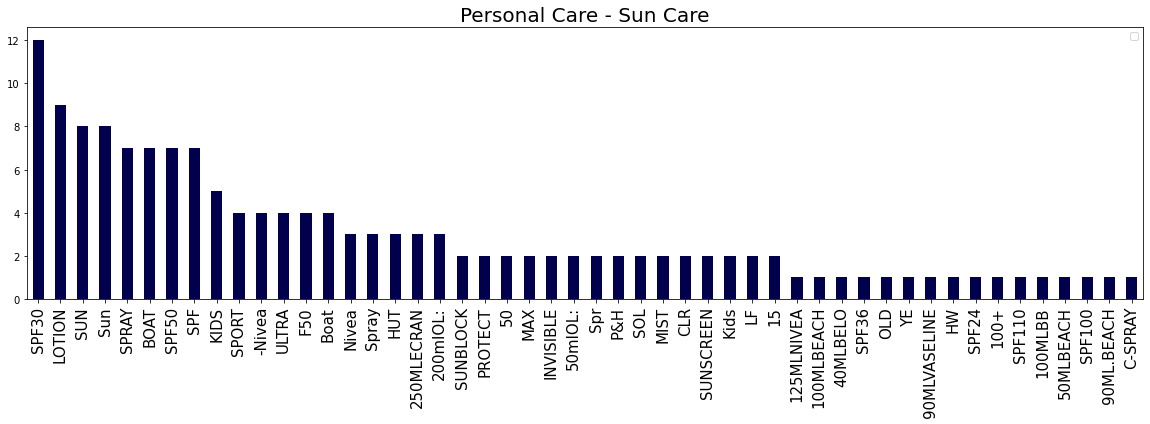

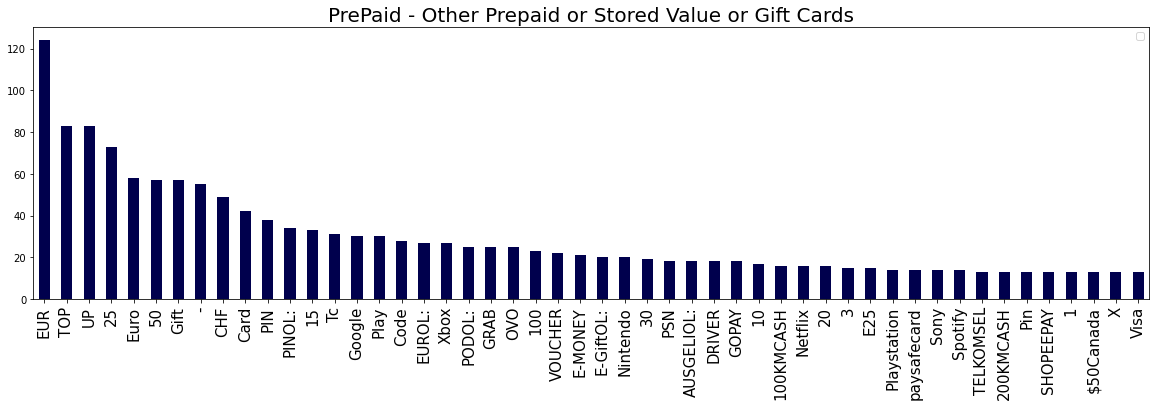

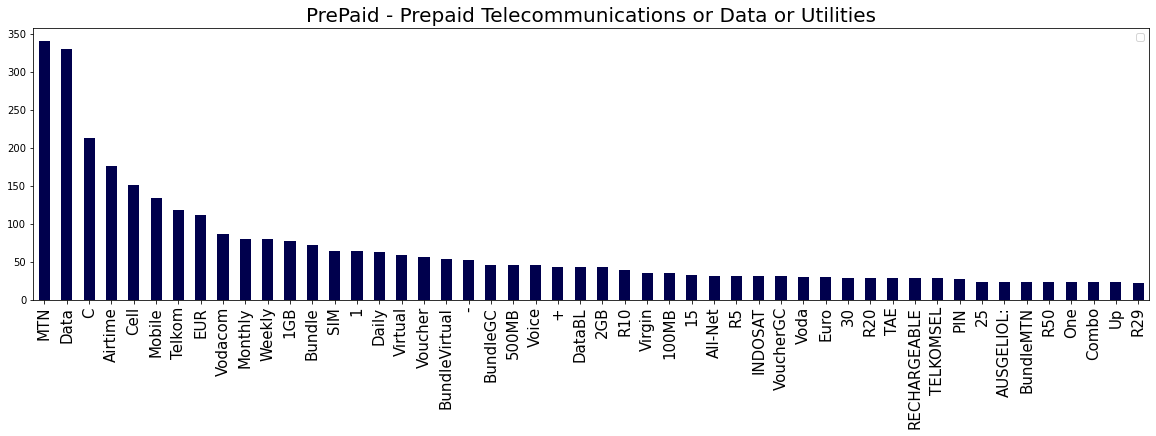

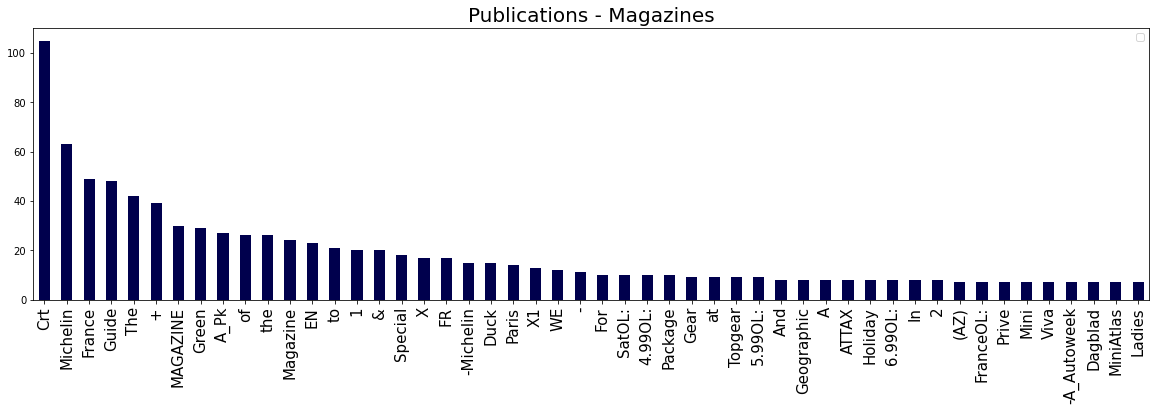

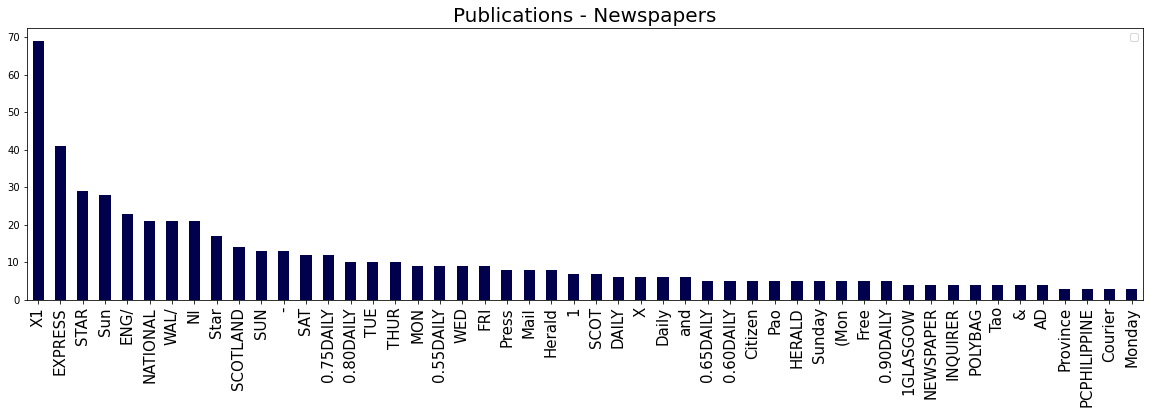

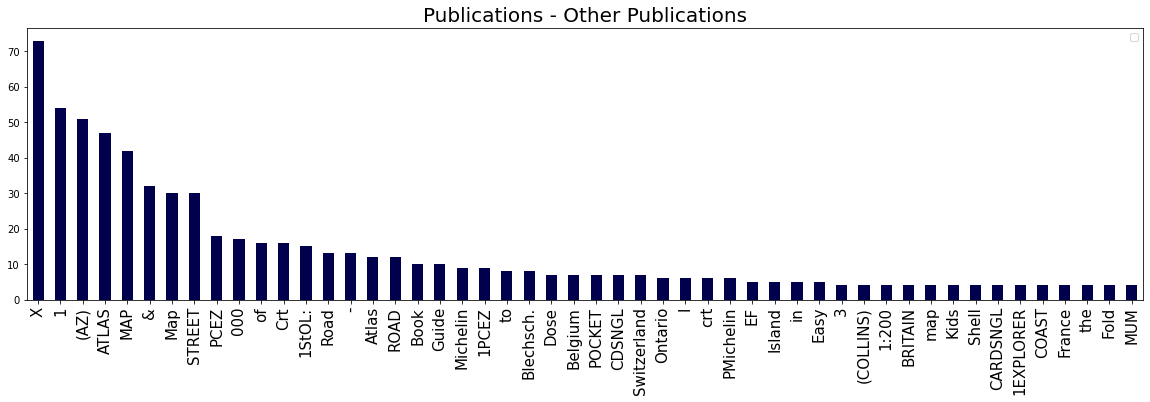

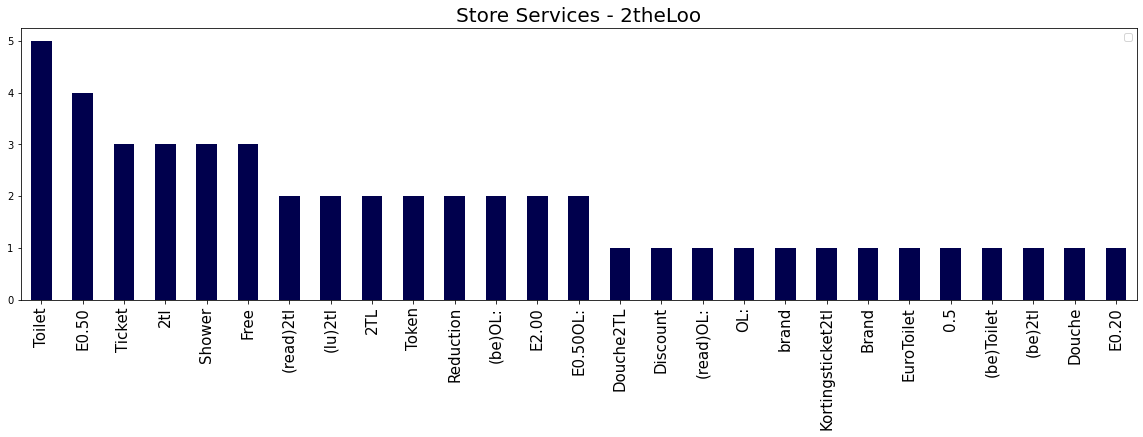

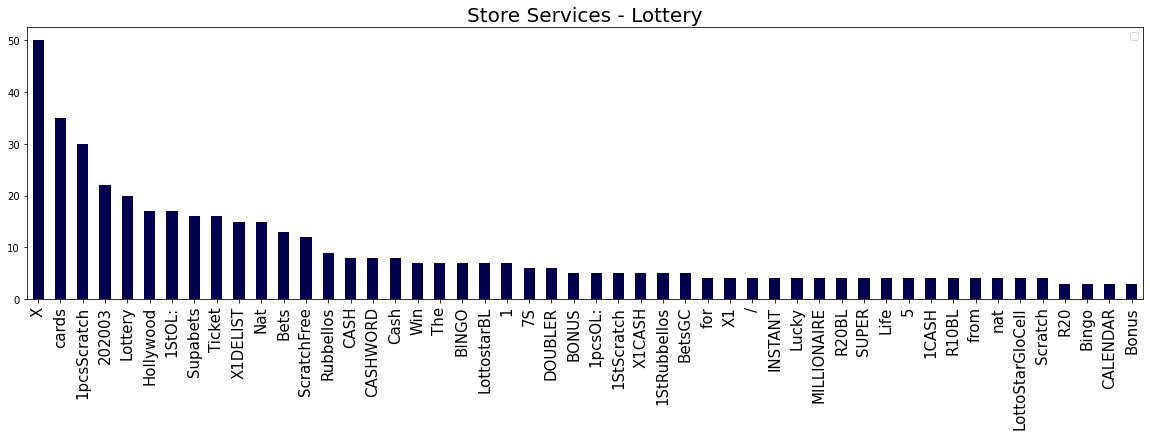

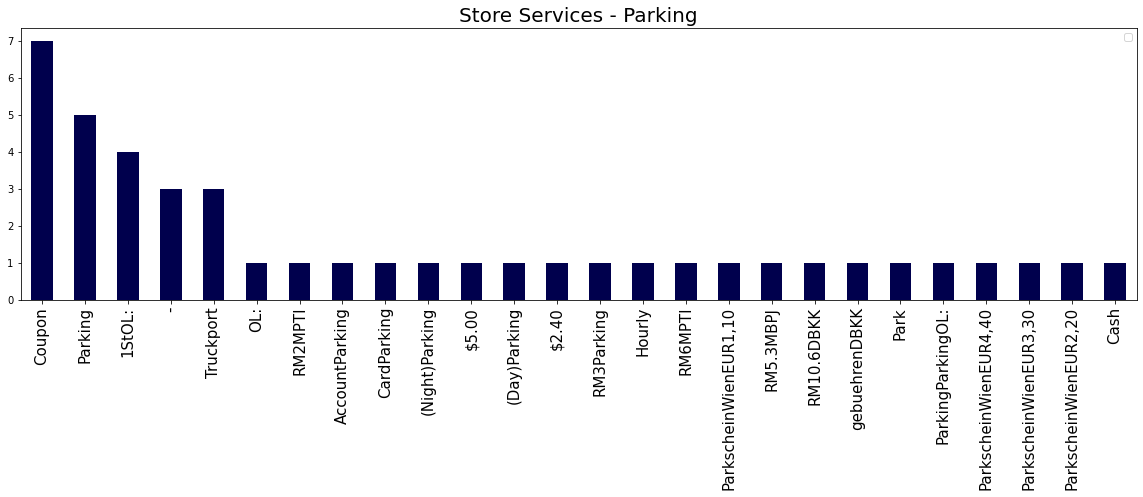

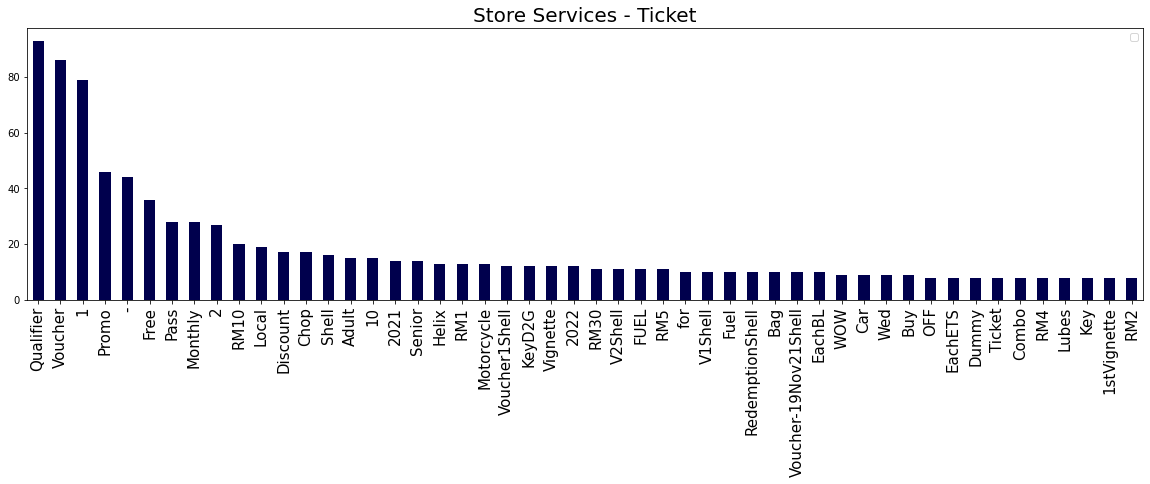

In [22]:
plot_most_common_features(X,df['Final_Category'])

In [23]:
nltk.download('stopwords')

from nltk.stem import SnowballStemmer


def stemming(raw_text):
    
    stemmer = SnowballStemmer('english')
    stemmed = [stemmer.stem(word) for word in raw_text]
    
    return("".join(stemmed))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S.Subramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
nltk.download('stopwords')

from nltk.stem import SnowballStemmer


def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    no_one_letter = re.sub(r"\b[a-zA-Z]\b","",letters_only)
    words = no_one_letter.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]

    final_words = [word for word in not_stop_words]
    
    return( " ".join( final_words ))  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S.Subramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
X_cleaner = X.apply(lambda x: process_text(x))

In [26]:
X_cleaner_2 = X_cleaner.apply(lambda x: stemming(x))

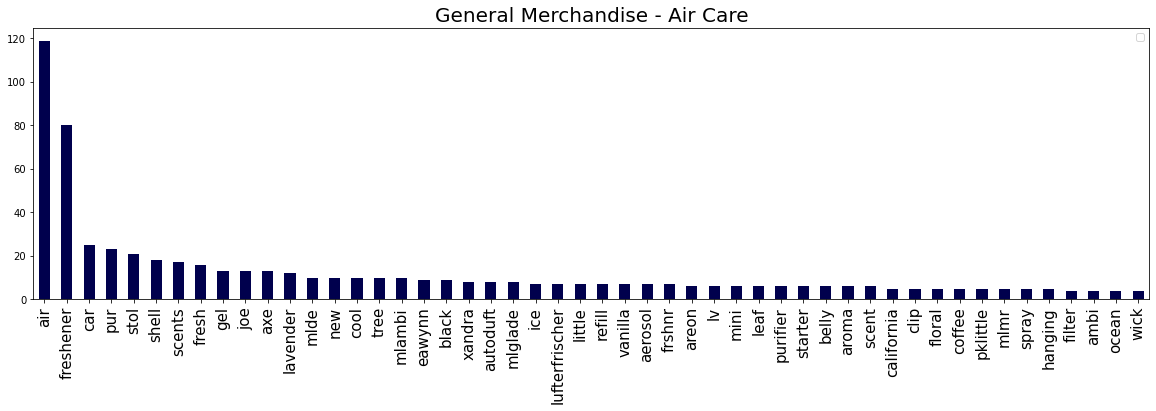

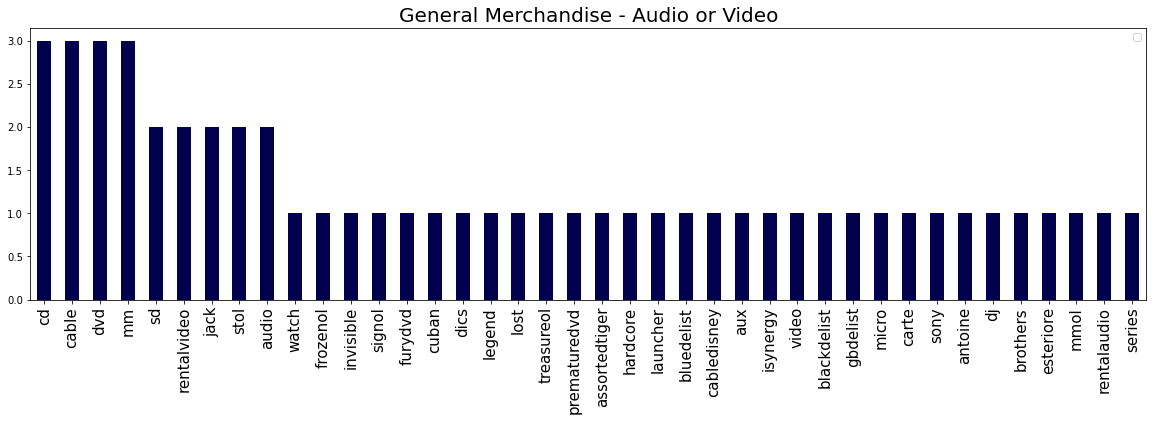

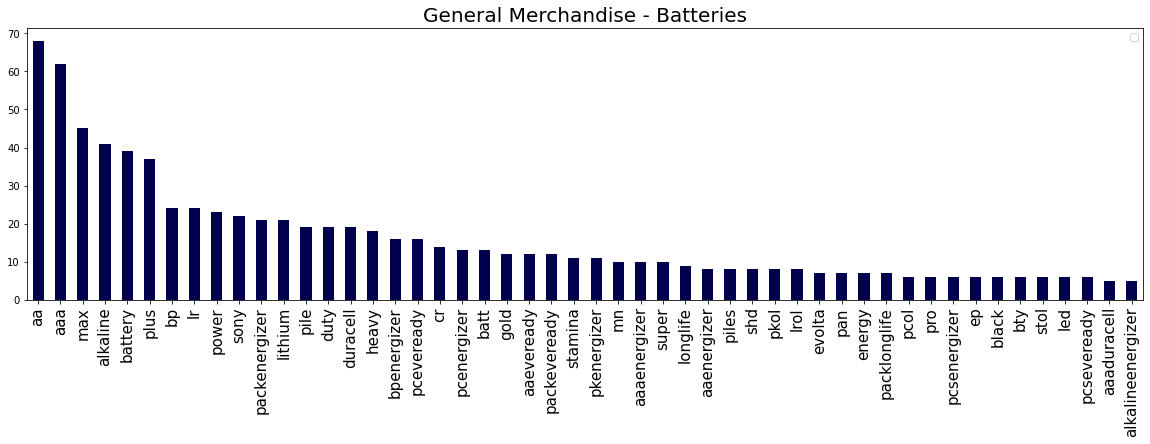

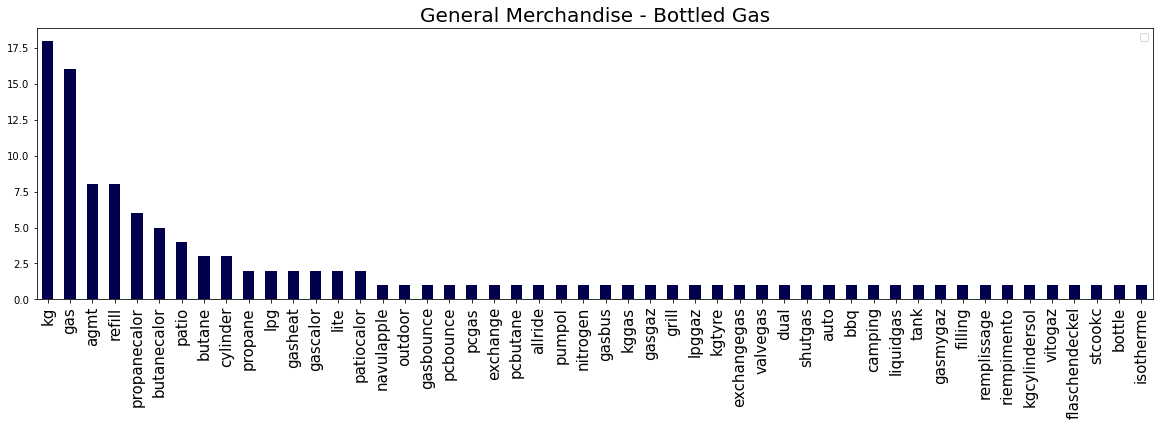

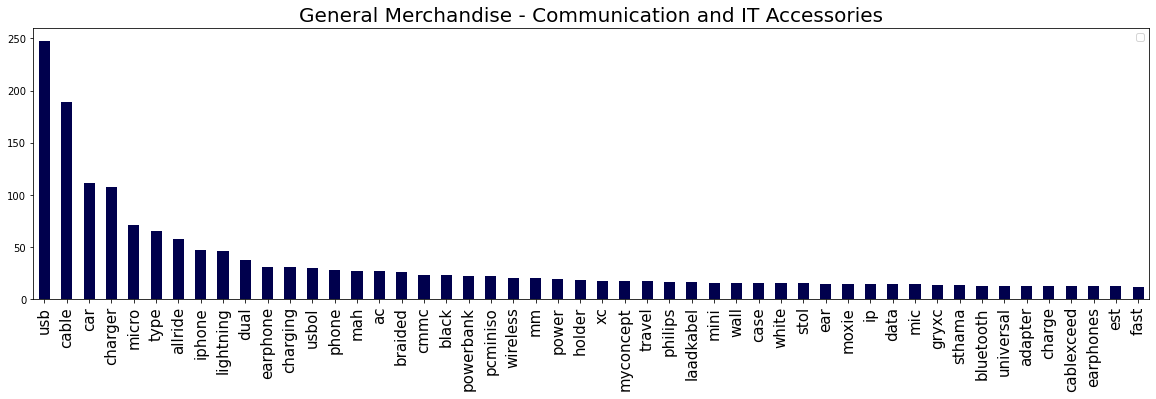

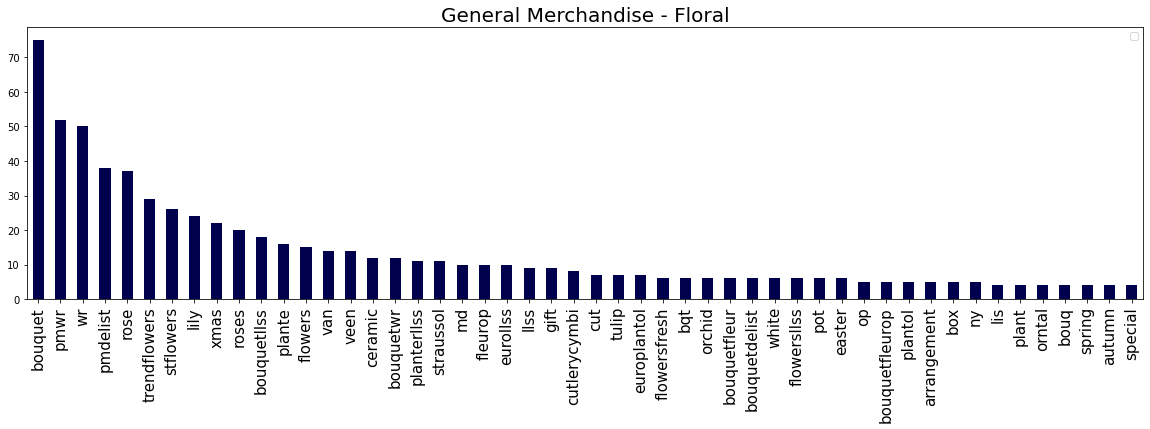

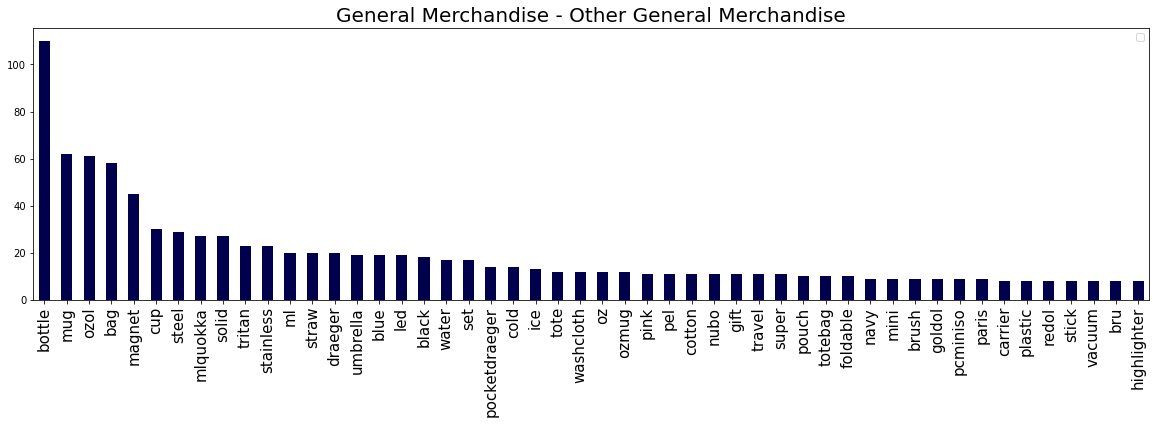

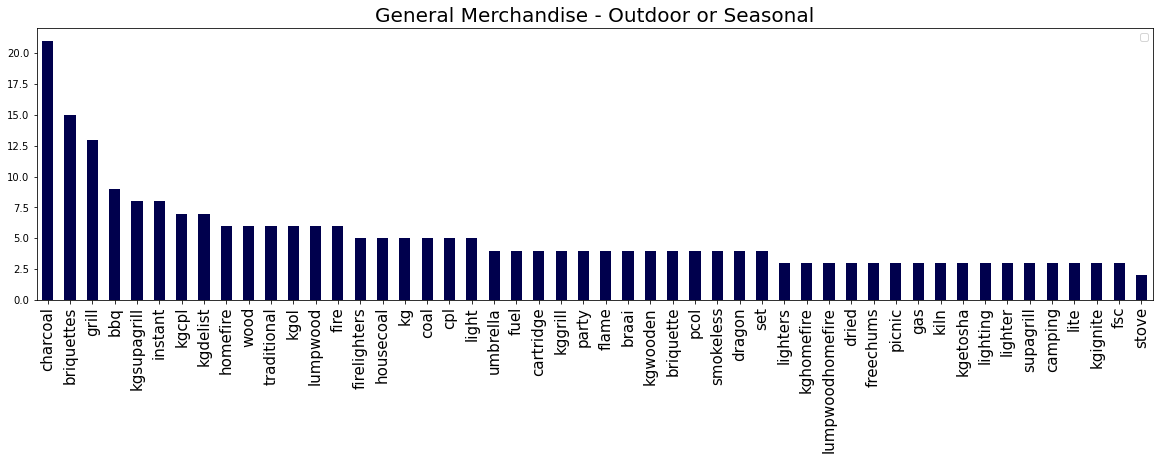

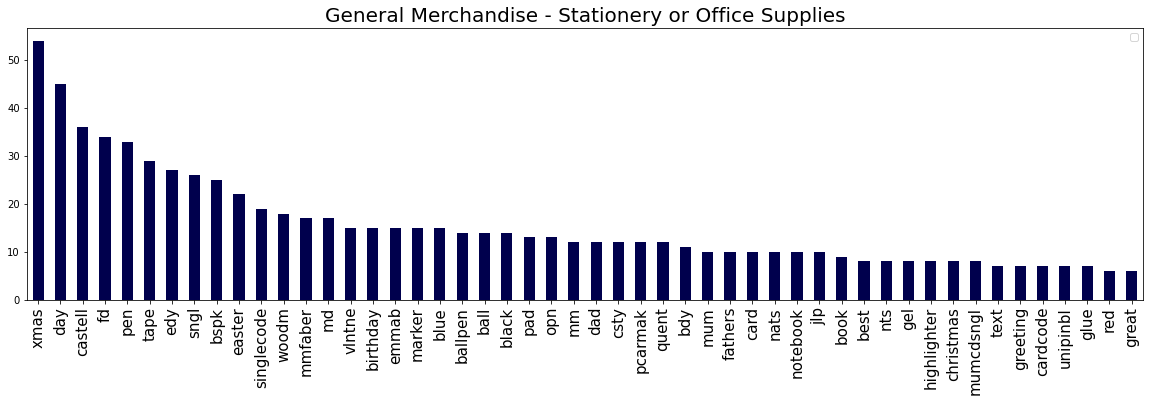

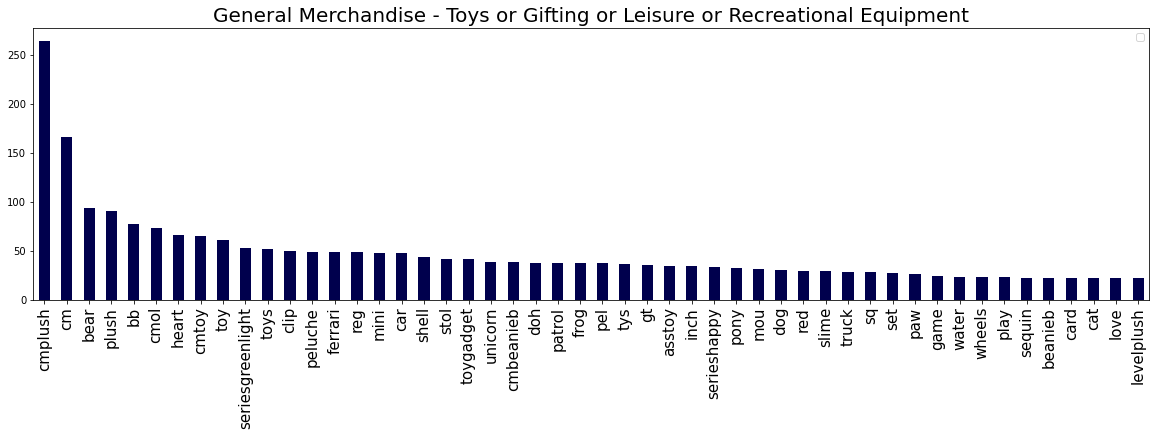

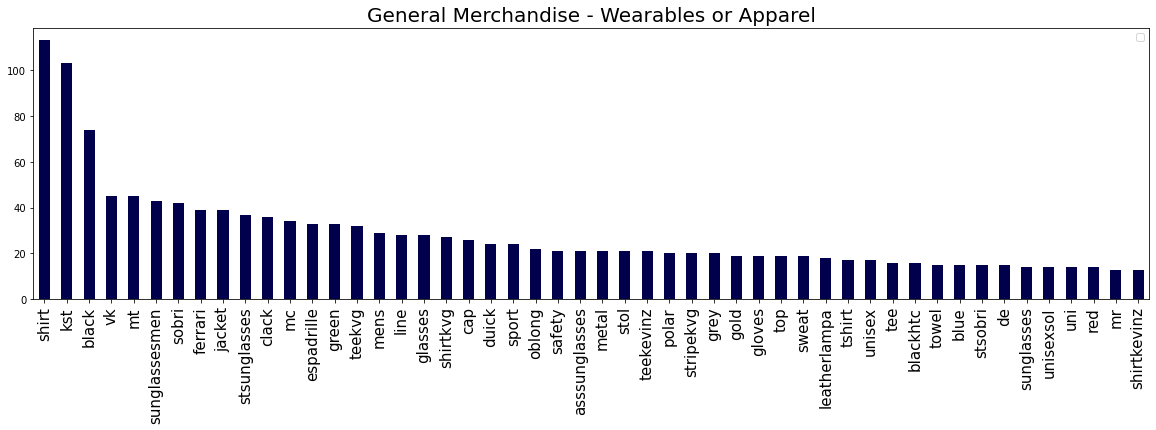

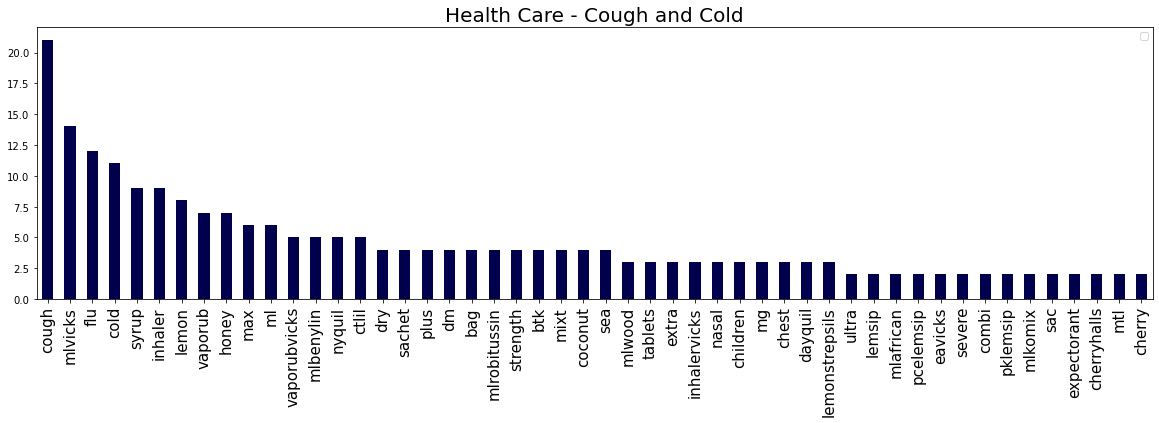

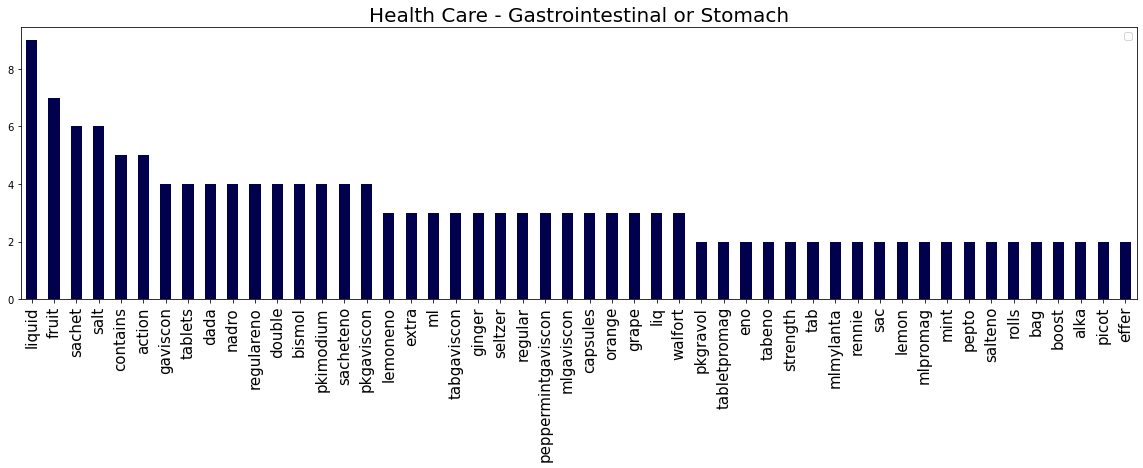

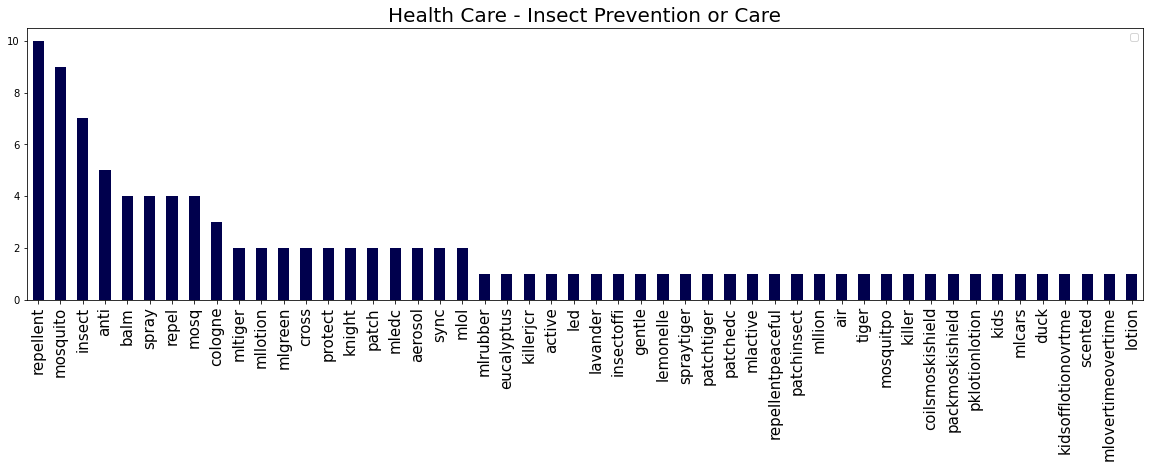

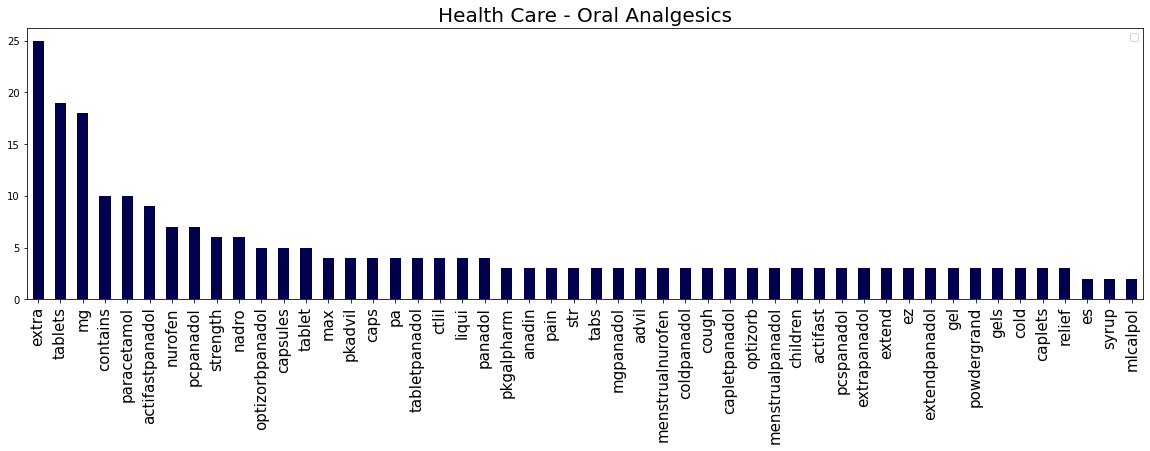

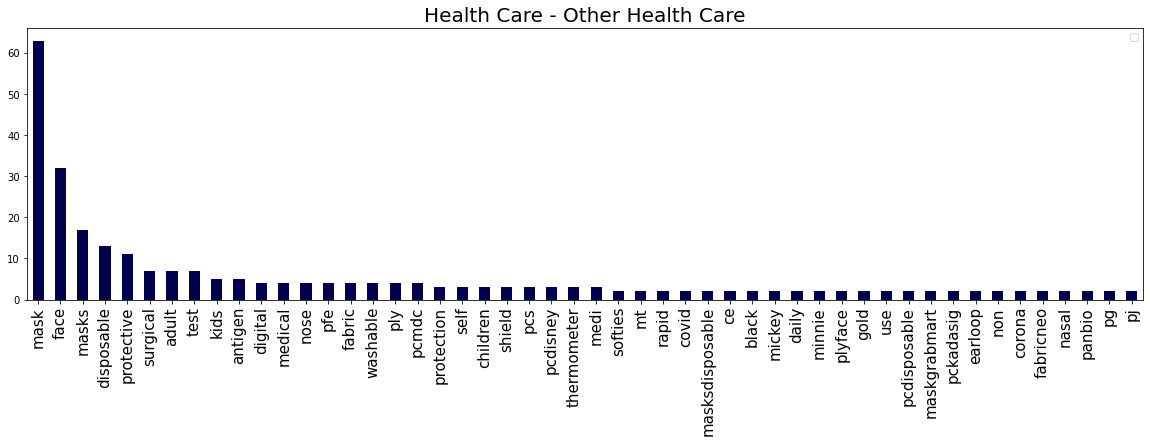

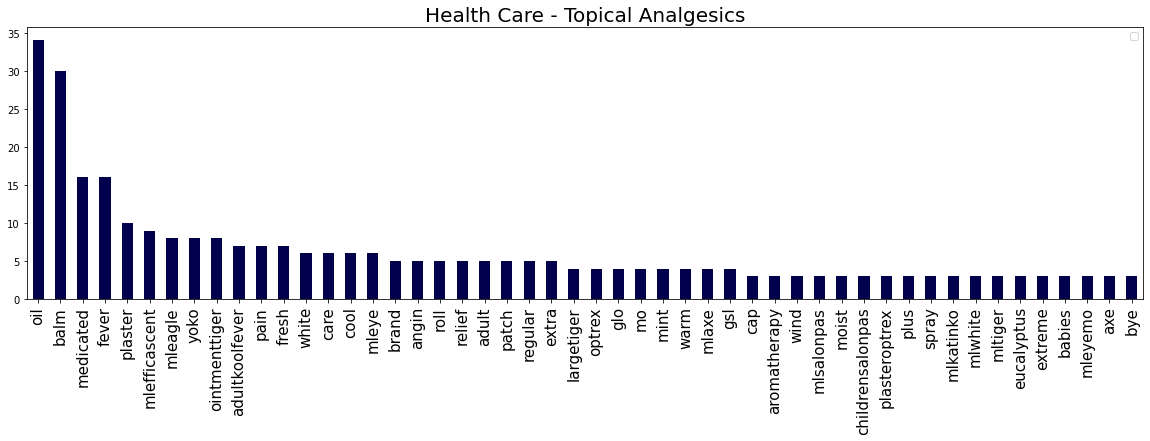

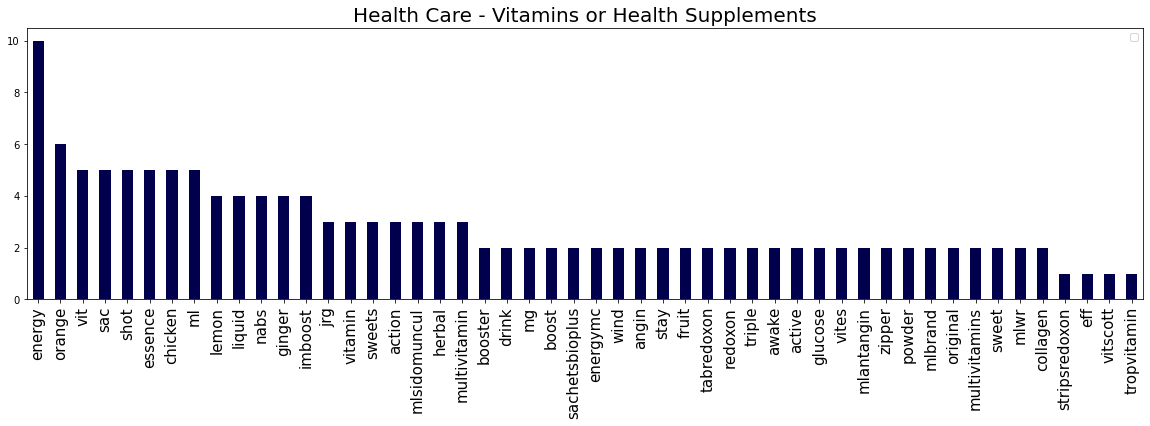

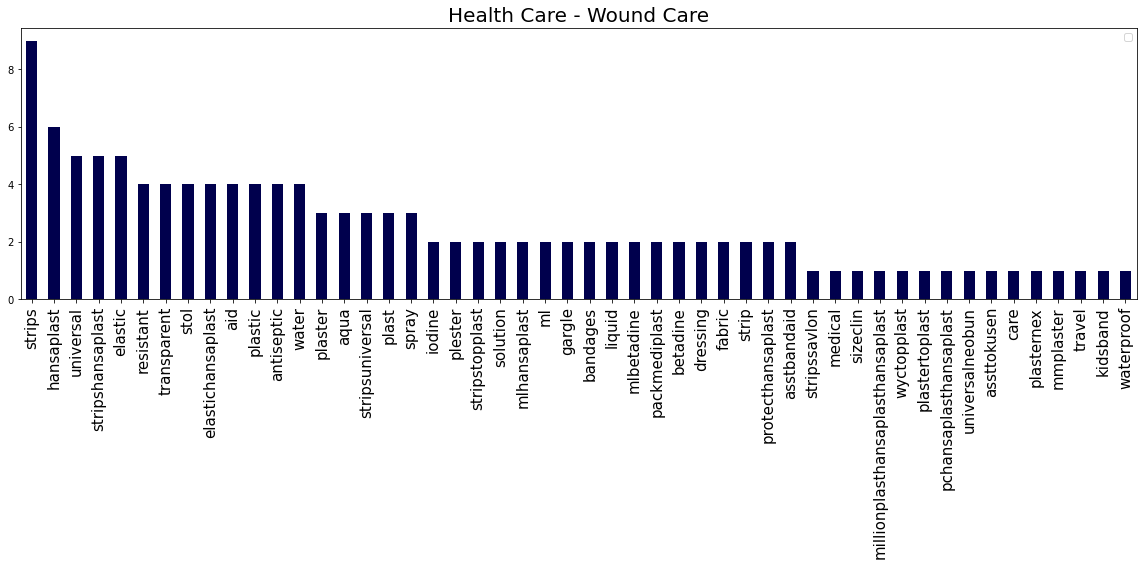

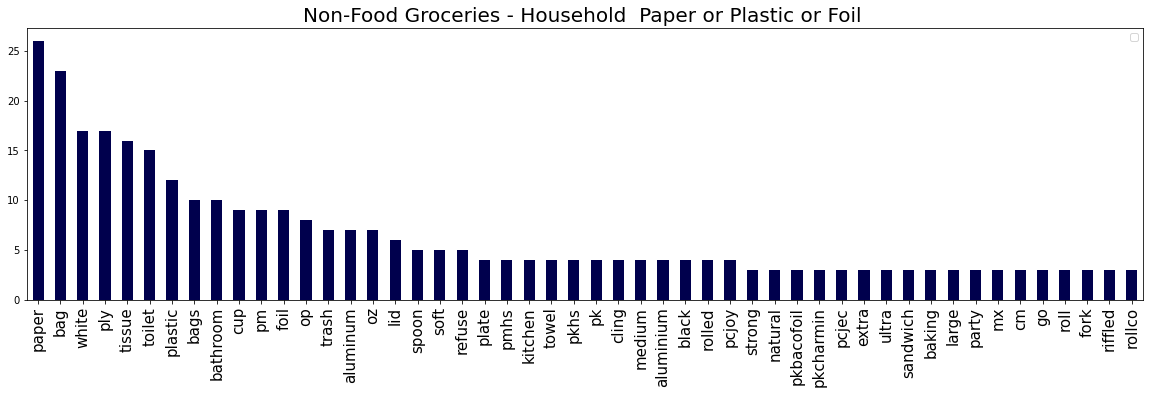

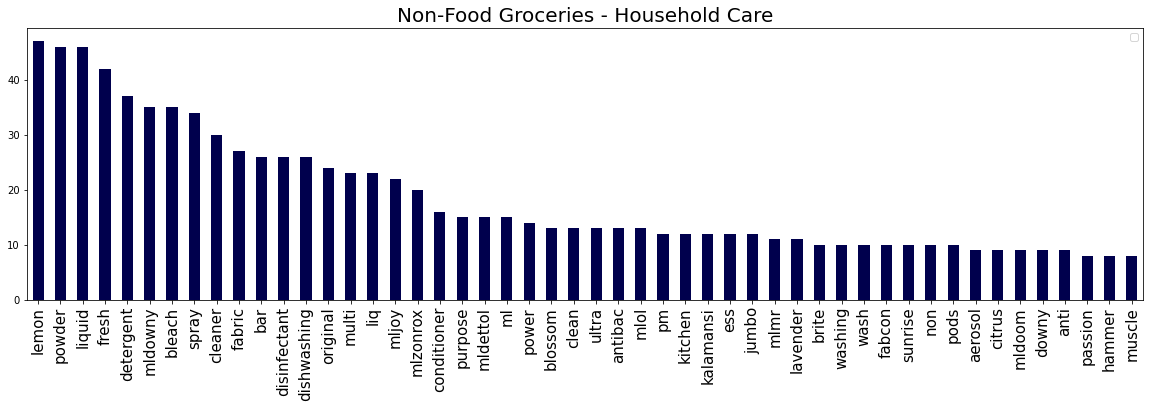

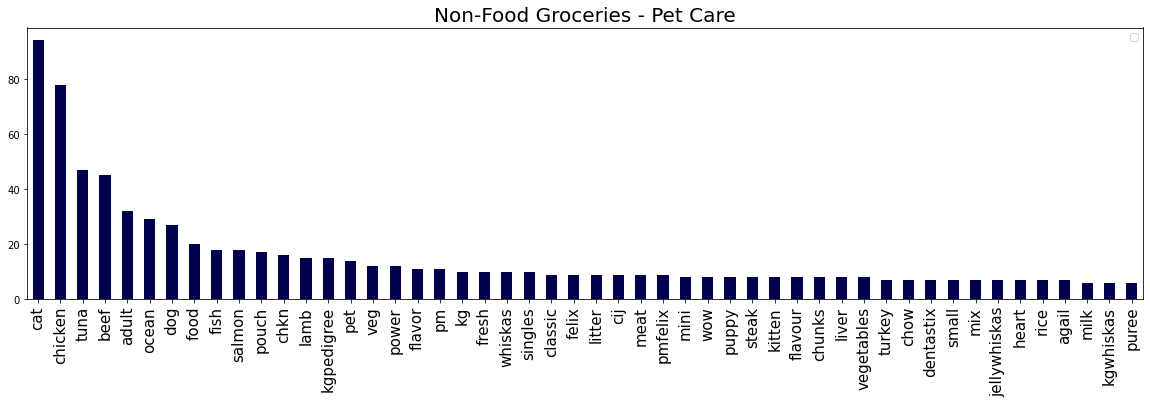

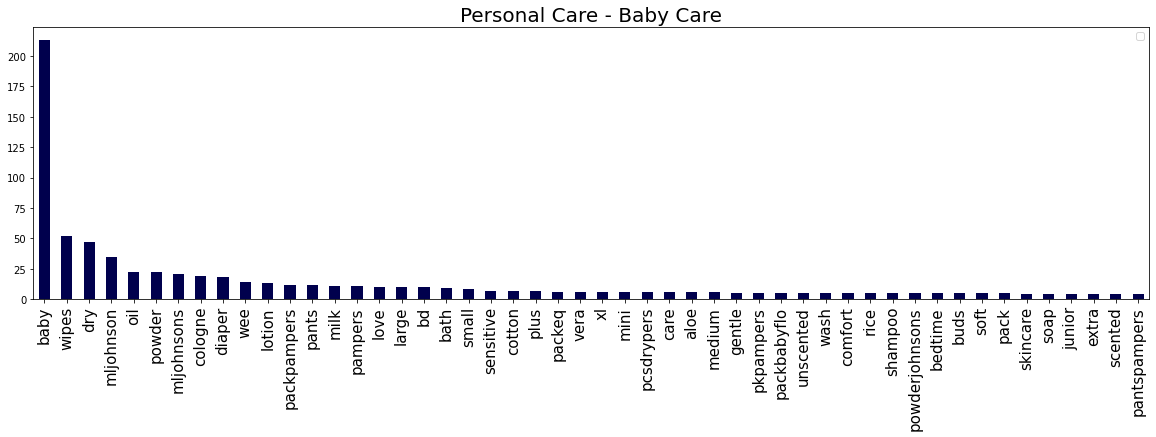

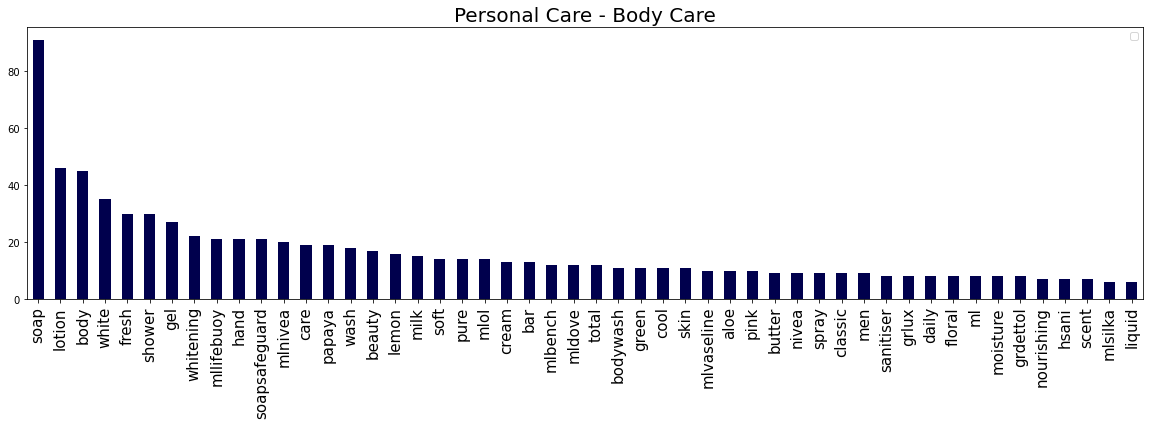

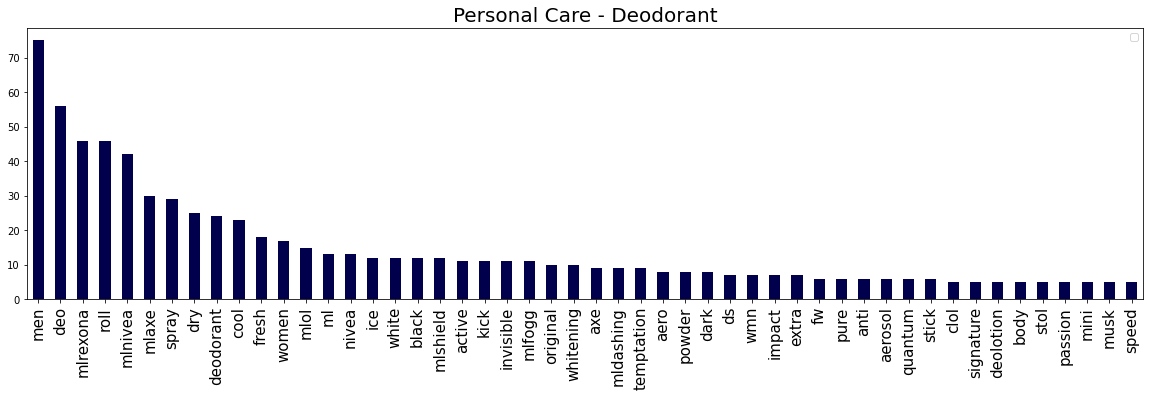

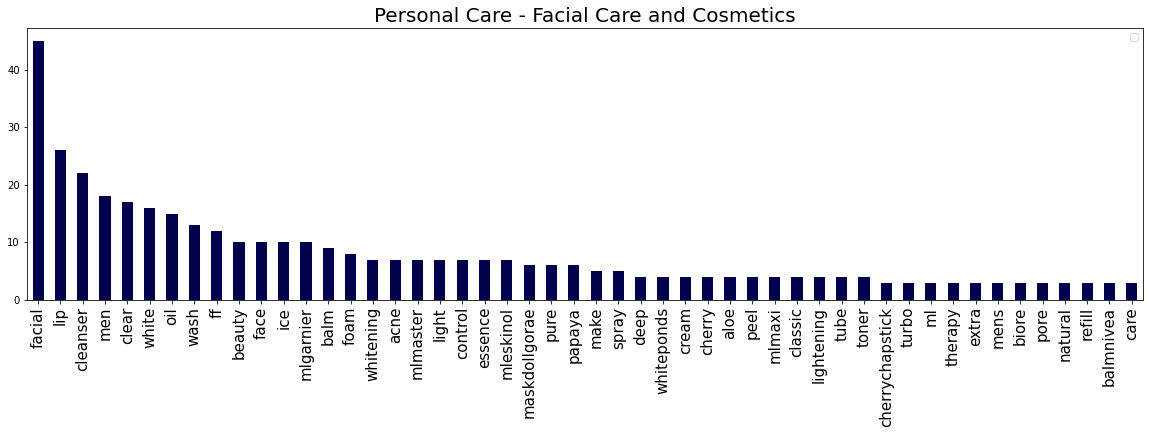

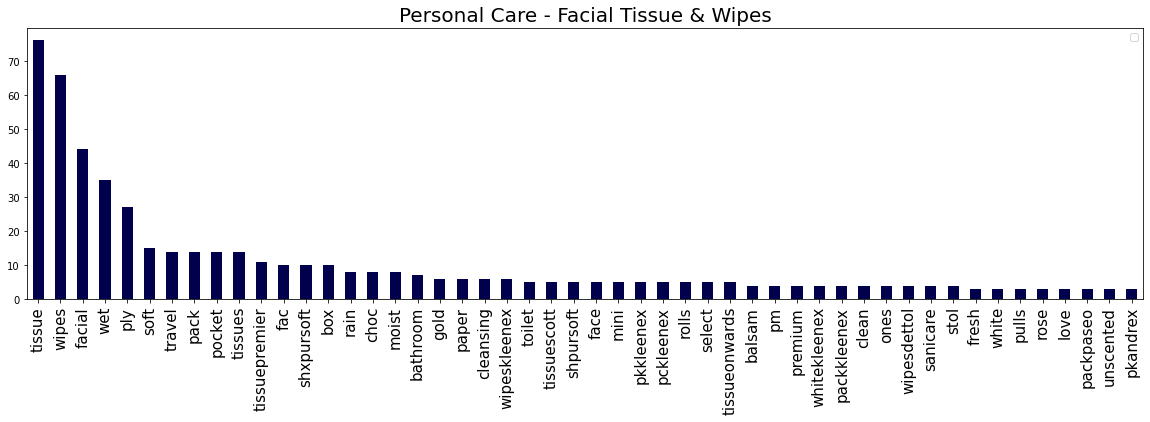

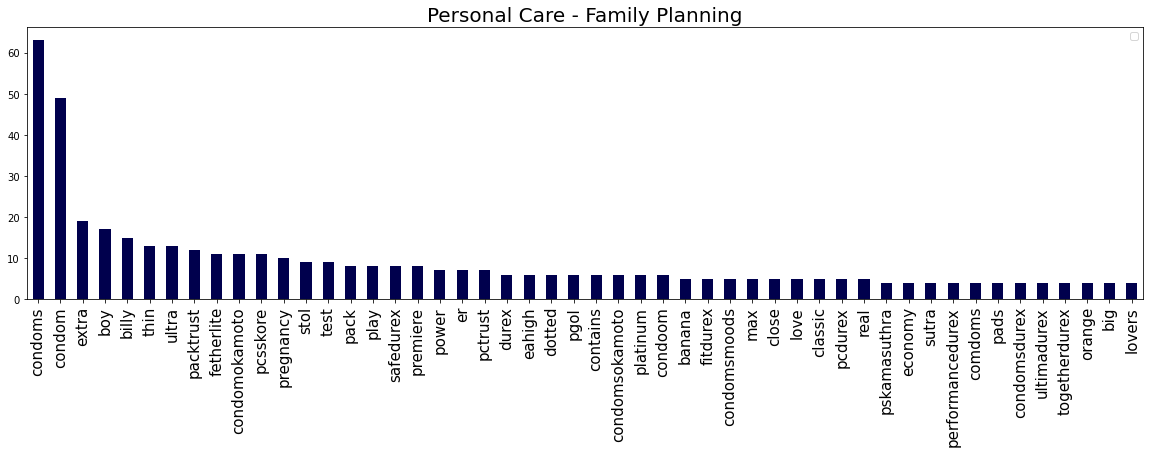

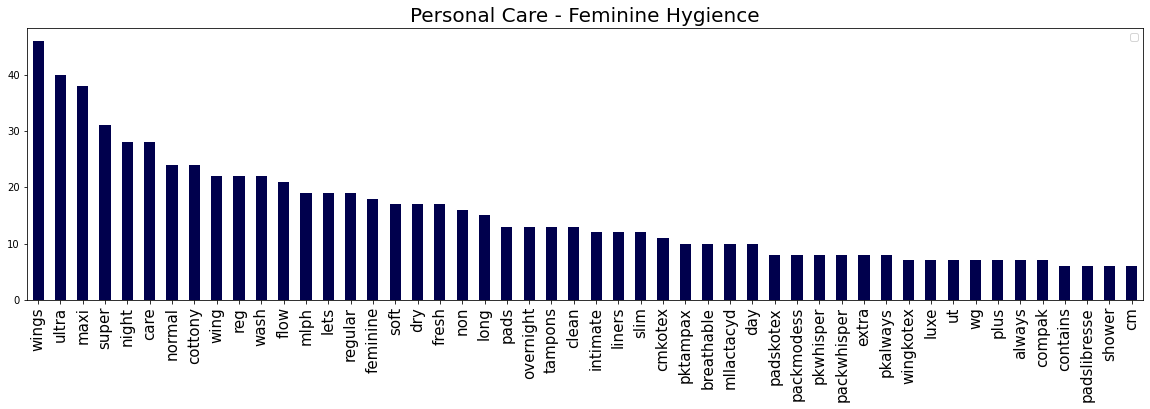

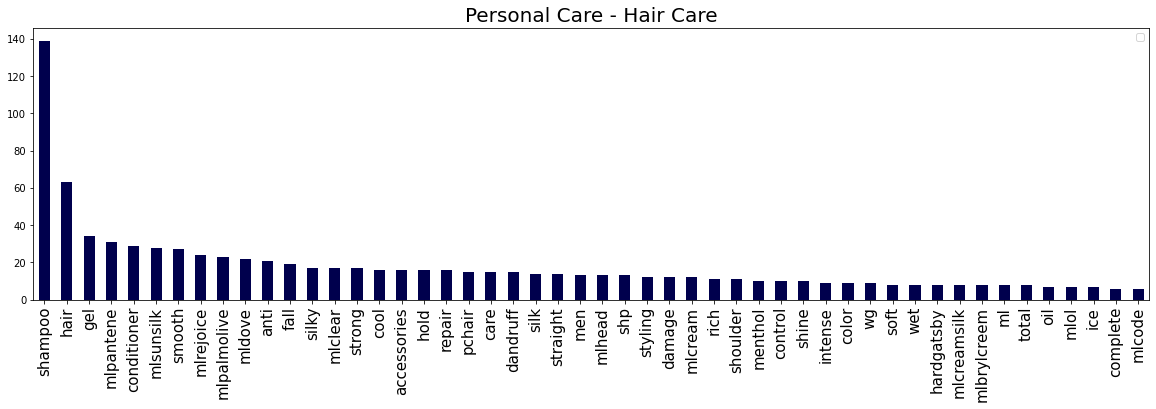

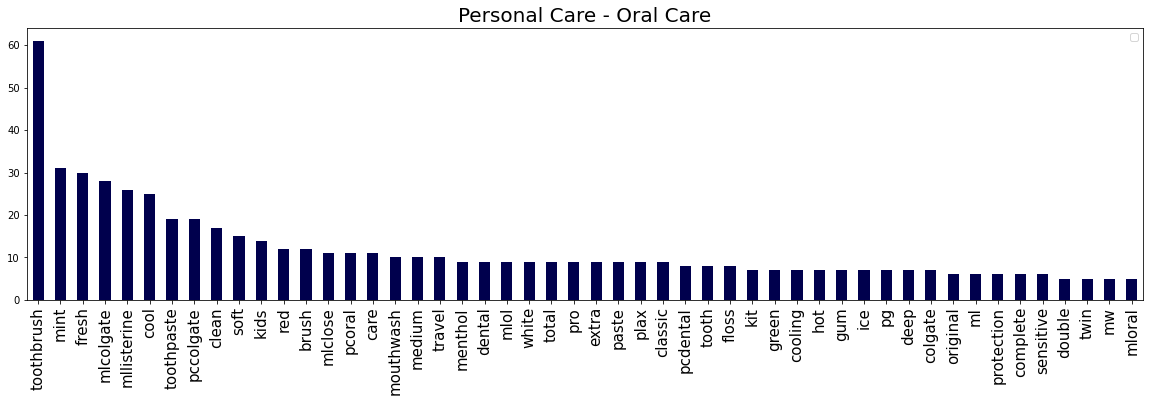

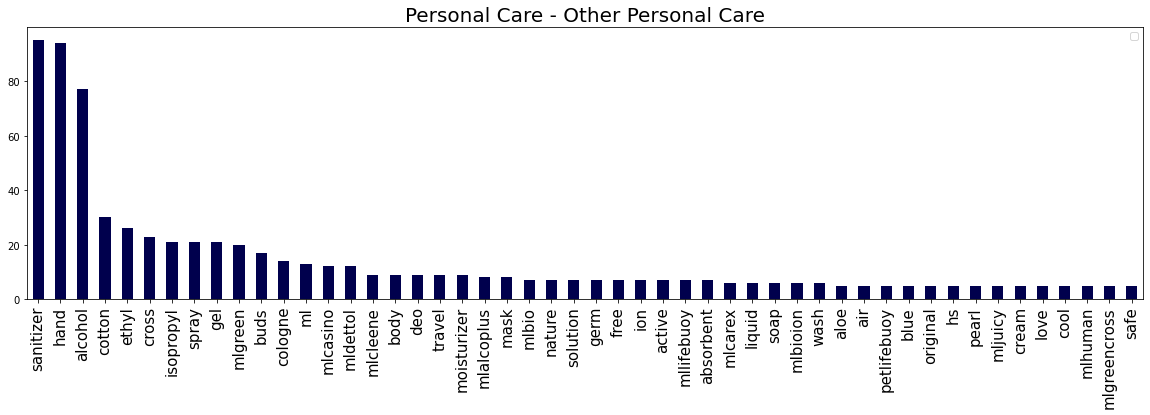

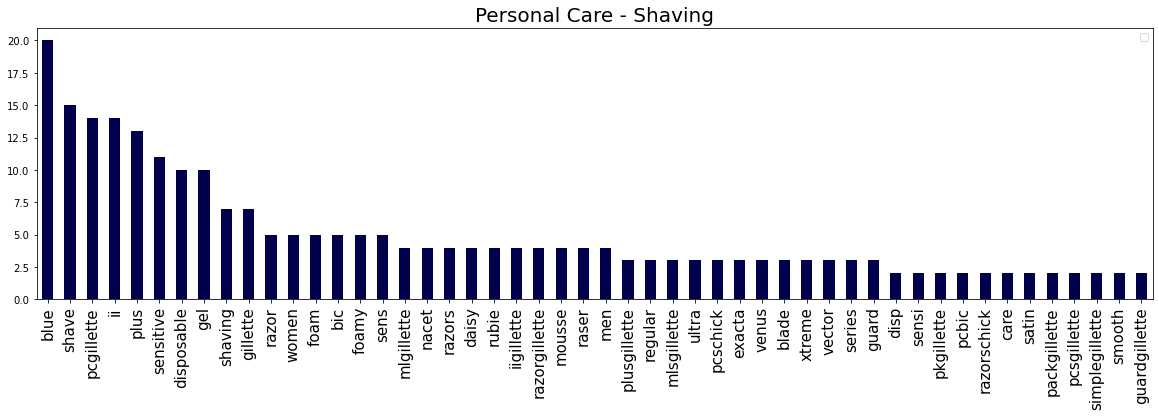

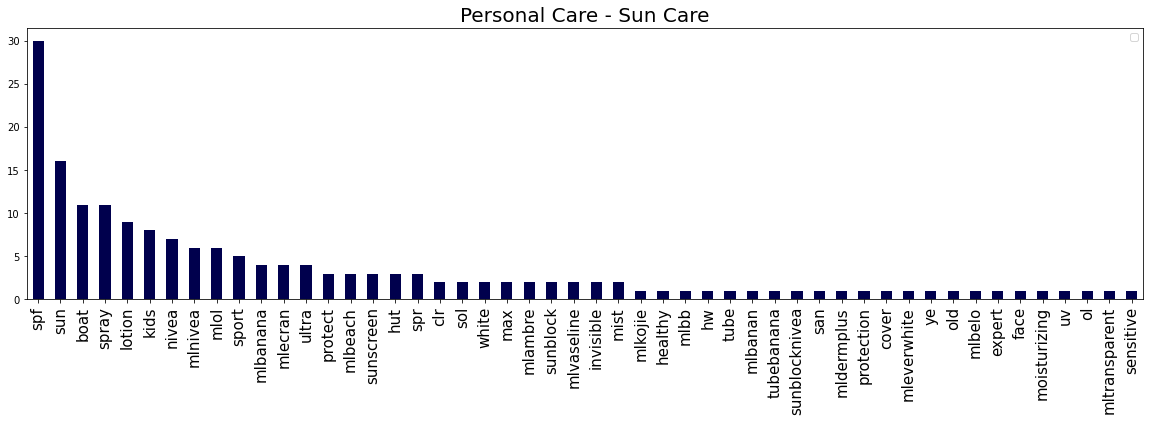

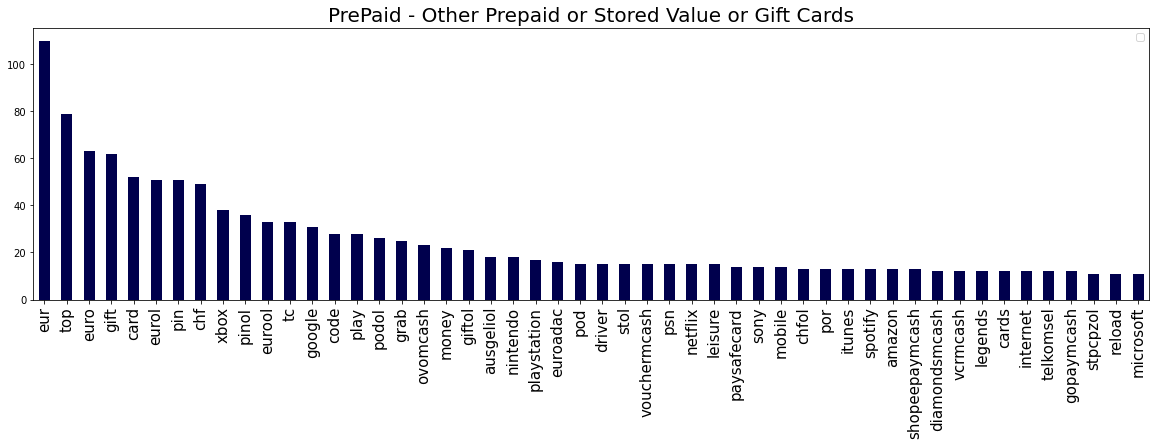

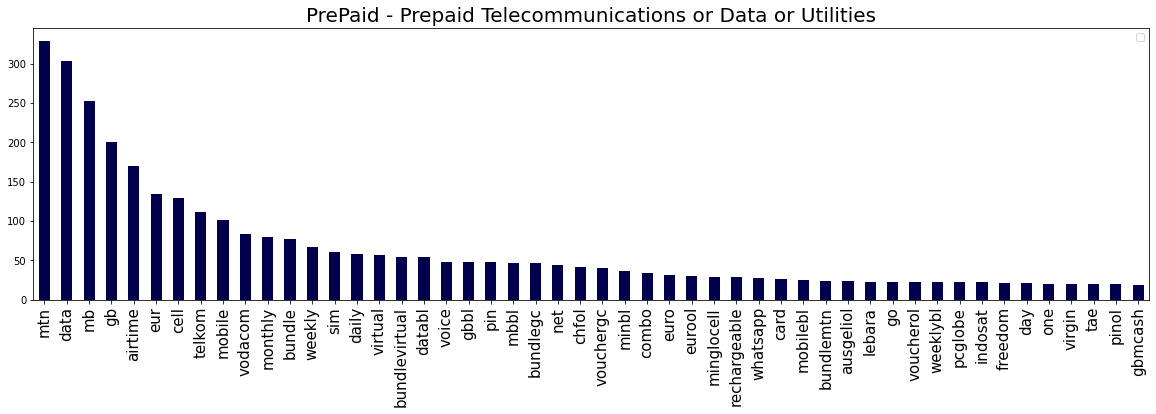

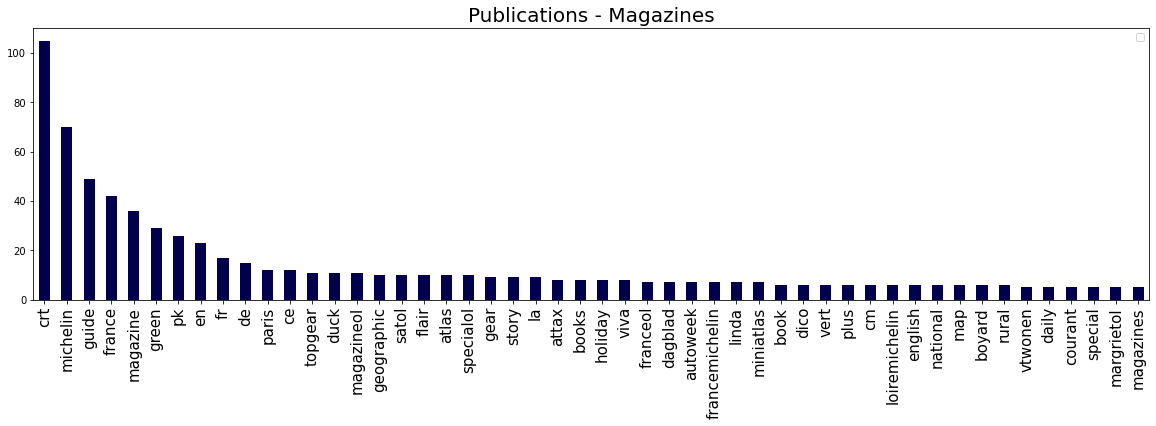

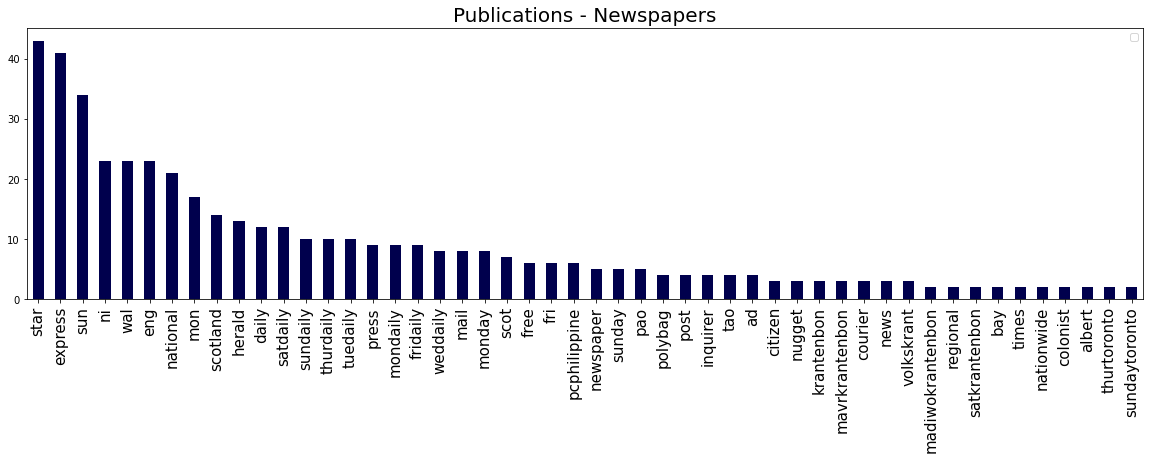

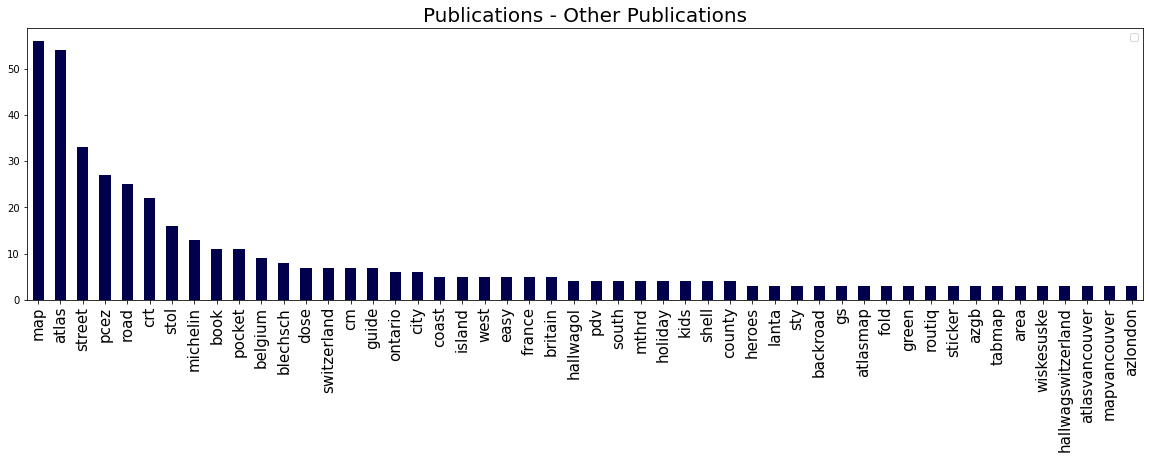

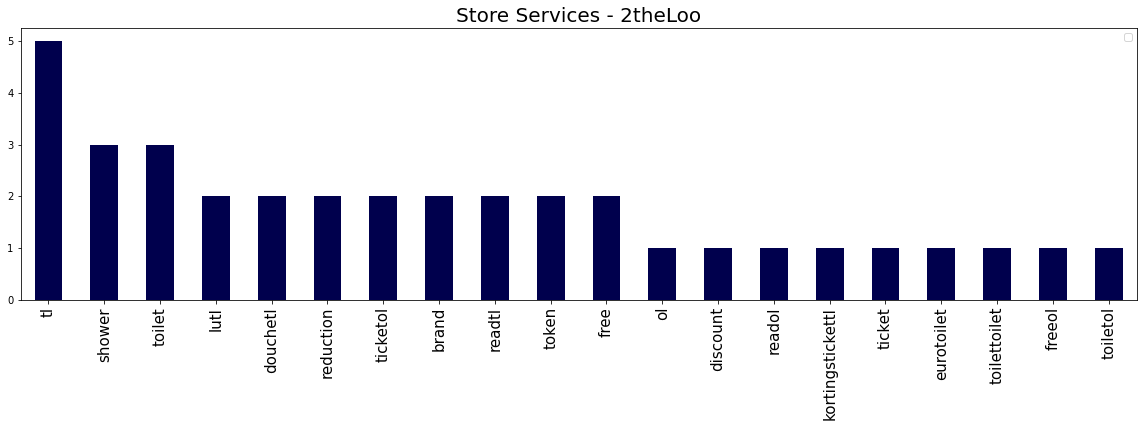

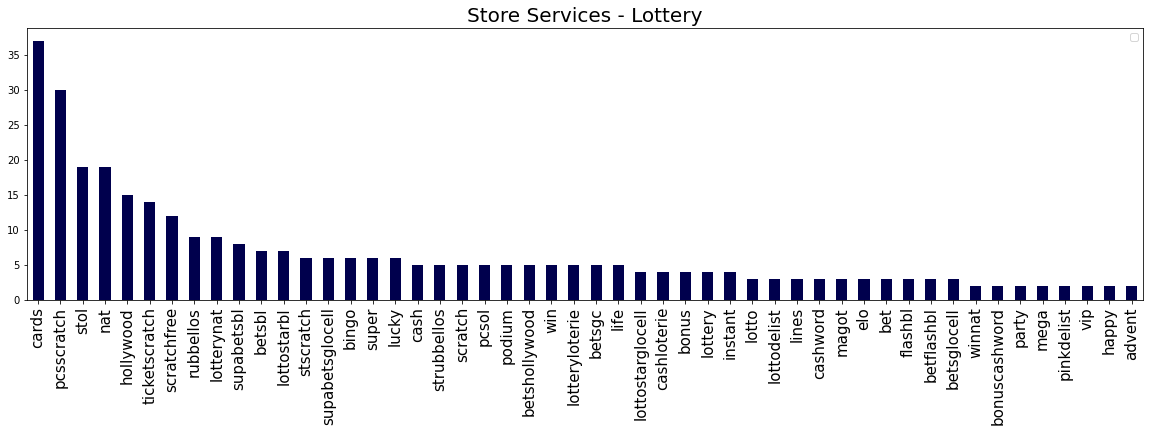

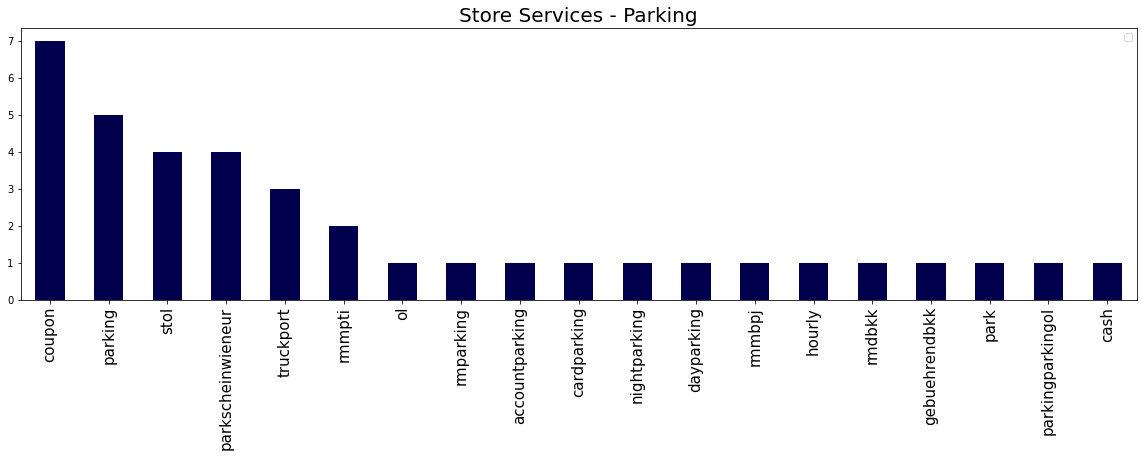

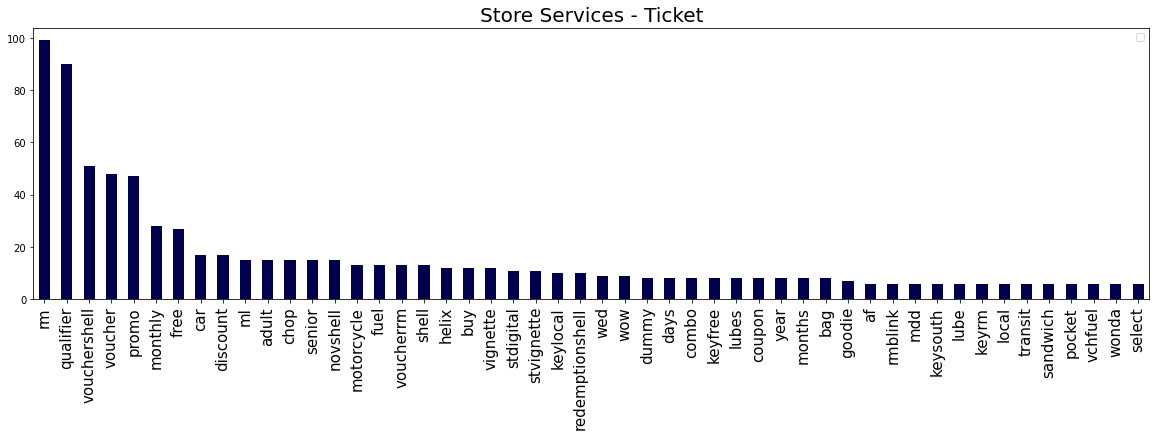

In [27]:
plot_most_common_features(X_cleaner_2,df['Final_Category'])

In [28]:
warnings.filterwarnings('ignore') # Do not print warning messages

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [30]:
def text_p(X):
    return X.apply(lambda x: process_text(x))  

In [31]:
def stemming_func(X):
    return X.apply(lambda x: stemming(x))

In [32]:
count_vect = CountVectorizer(analyzer = "word")
tfidf = TfidfTransformer(norm="l2")

In [33]:
text_process = FunctionTransformer(text_p)
stemming_text = FunctionTransformer(stemming_func)

In [34]:
naive_multi = MultinomialNB()
svc = SVC()
rf = RandomForestClassifier(n_jobs=-1)
lr = LogisticRegression(multi_class='ovr')

In [35]:
pipeline = Pipeline([
    ('process', text_process),
    ('stemmer', stemming_text),
    ('count_vector', count_vect),
    ('tfidf', tfidf),
    ('model', naive_multi)
])
pipeline

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x000002077493AD30>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x000002077493A820>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

In [36]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x000002077493AD30>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x000002077493A820>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
matthews_corrcoef(y_train, pipeline.predict(X_train))

0.7933636483639901

In [39]:
recall_score(y_train, pipeline.predict(X_train), average='macro')

0.5542967721865645

In [40]:
#GridSearch

In [41]:
Cs = 10**np.linspace(-1,2,3)
gammas = 10**np.linspace(-2,1,5)

In [42]:
param_grid = [
    {'model': [svc], 'model__kernel': ['linear'], 'model__C': Cs, 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [svc], 'model__kernel': ['rbf'], 'model__gamma': gammas, 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [naive_multi], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [lr], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [rf], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]}
]

In [43]:
cv = ShuffleSplit(n_splits=5, test_size=0.2)

In [44]:
sklearn.metrics.get_scorer

<function sklearn.metrics._scorer.get_scorer(scoring)>

In [45]:
#%%time
#gs = GridSearchCV(
    #pipeline,
    #param_grid,
    #cv = cv,
    #n_jobs=-1
    #scoring=make_scorer(matthews_corrcoef)
#)
#gs.fit(X_train, y_train)

In [46]:
#gs = gs.fit(X_train, y_train)

In [47]:
from sklearn.model_selection import RandomizedSearchCV

In [48]:
randcv = RandomizedSearchCV(pipeline,param_grid,cv = cv,n_iter=10,scoring=make_scorer(matthews_corrcoef),verbose=10)
randcv.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model=SVC(), model__gamma=0.05623413251903491, model__kernel=rbf, stemmer=None, tfidf=TfidfTransformer()
[CV 1/5; 1/10] END model=SVC(), model__gamma=0.05623413251903491, model__kernel=rbf, stemmer=None, tfidf=TfidfTransformer();, score=0.601 total time=  24.7s
[CV 2/5; 1/10] START model=SVC(), model__gamma=0.05623413251903491, model__kernel=rbf, stemmer=None, tfidf=TfidfTransformer()
[CV 2/5; 1/10] END model=SVC(), model__gamma=0.05623413251903491, model__kernel=rbf, stemmer=None, tfidf=TfidfTransformer();, score=0.596 total time=  24.2s
[CV 3/5; 1/10] START model=SVC(), model__gamma=0.05623413251903491, model__kernel=rbf, stemmer=None, tfidf=TfidfTransformer()
[CV 3/5; 1/10] END model=SVC(), model__gamma=0.05623413251903491, model__kernel=rbf, stemmer=None, tfidf=TfidfTransformer();, score=0.597 total time=  24.1s
[CV 4/5; 1/10] START model=SVC(), model__gamma=0.05623413251903491, model__kernel=rbf, ste

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('process',
                                              FunctionTransformer(func=<function text_p at 0x000002077493AD30>)),
                                             ('stemmer',
                                              FunctionTransformer(func=<function stemming_func at 0x000002077493A820>)),
                                             ('count_vector',
                                              CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('model'...
                                        {'model': [LogisticRegression(multi_class='ovr')],
                                         'stemmer': [None,
                                                     FunctionTransformer(func=<function stemming_func at 0x000002077493A820>)],
                                         'tfidf': [None, TfidfTransformer()]},
                                        {'model': [RandomForestClassifier(n_jobs=-1)],
                                         'stemmer': [None,
                                                     FunctionTransformer(func=<function stemming_func at 0x000002077493A820>)],
                                         'tfidf': [None, TfidfTransformer()]}],
                   scoring=make_scorer(matthews_corrcoef), verbose=10)

In [49]:
#gs_results = pd.DataFrame(gs.cv_results_).sort_values(['rank_test_score'])
#gs_results.head()

In [50]:
randcv_results = pd.DataFrame(randcv.cv_results_).sort_values(['rank_test_score'])
randcv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      24.466600      3.582446         5.981641        0.201712   
2      24.076739      0.921156         5.617151        0.584508   
7      22.527075      2.762897         5.921599        0.095980   
5      11.376423      1.120846         1.888870        0.049646   
4      38.423920      2.750948         7.253558        0.088061   

          param_tfidf                                      param_stemmer  \
1  TfidfTransformer()  FunctionTransformer(func=<function stemming_fu...   
2  TfidfTransformer()                                               None   
7  TfidfTransformer()  FunctionTransformer(func=<function stemming_fu...   
5                None                                               None   
4                None  FunctionTransformer(func=<function stemming_fu...   

  param_model__kernel param_model__gamma  \
1              linear                NaN   
2              linear                NaN   
7              linear                NaN   
5                 NaN                NaN   
4                 rbf           0.316228   

                                  param_model param_model__C  \
1  SVC(C=3.1622776601683795, kernel='linear')       3.162278   
2  SVC(C=3.1622776601683795, kernel='linear')          100.0   
7  SVC(C=3.1622776601683795, kernel='linear')          100.0   
5           RandomForestClassifier(n_jobs=-1)            NaN   
4  SVC(C=3.1622776601683795, kernel='linear')            NaN   

                                              params  split0_test_score  \
1  {'tfidf': TfidfTransformer(), 'stemmer': Funct...           0.861828   
2  {'tfidf': TfidfTransformer(), 'stemmer': None,...           0.858344   
7  {'tfidf': TfidfTransformer(), 'stemmer': Funct...           0.858344   
5  {'tfidf': None, 'stemmer': None, 'model': Rand...           0.812889   
4  {'tfidf': None, 'stemmer': FunctionTransformer...           0.795305   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
1           0.852490           0.858179           0.861754           0.864011   
2           0.854141           0.861066           0.856521           0.864004   
7           0.854141           0.861066           0.856521           0.864004   
5           0.815317           0.813205           0.823284           0.811415   
4           0.794563           0.795194           0.802061           0.801231   

   mean_test_score  std_test_score  rank_test_score  
1         0.859652        0.004040                1  
2         0.858815        0.003445                2  
7         0.858815        0.003445                2  
5         0.815222        0.004219                4  
4         0.797671        0.003266                5

In [51]:
randcv.best_score_

0.8596523026673015

In [52]:
#gs.best_score_

In [53]:
#best_params = gs.best_estimator_.get_params()

In [54]:
best_params = randcv.best_estimator_.get_params()

In [55]:
pipeline.set_params(**best_params)

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x000002077493AD30>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x000002077493A820>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('model', SVC(C=3.1622776601683795, kernel='linear'))])

In [56]:
matthews_corrcoef(y_test, pipeline.predict(X_test))

0.8642012186374727

(array([ 1.,  1.,  0.,  1.,  3.,  1.,  6., 12.,  9.,  9.]),
 array([0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 10 artists>)

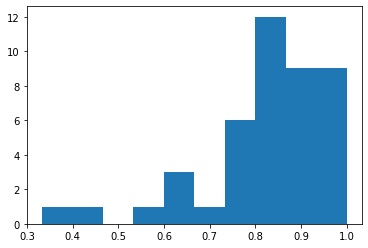

In [57]:
plt.hist(recall_score(y_test, pipeline.predict(X_test), average=None))

(array([0.02325581, 0.04651163, 0.04651163, 0.06976744, 0.13953488,
        0.1627907 , 0.30232558, 0.58139535, 0.79069767, 1.        ]),
 array([0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 10 artists>)

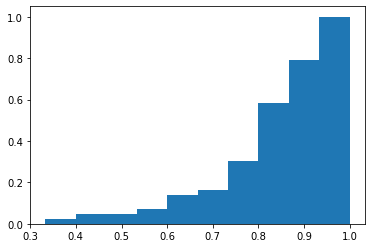

In [58]:
plt.hist(recall_score(y_test, pipeline.predict(X_test), average=None), cumulative=True, density=True)

In [59]:
recall_score(y_test, pipeline.predict(X_test), average='macro')

0.8277967367870556

In [60]:
test_set = pd.read_excel('test_set2_9.xlsx')

In [61]:
final_prediction = pd.DataFrame(X_test.copy())

In [62]:
test_set['Prediction'] = pipeline.predict(test_set['Production Description Test'])

In [63]:
test_set.head(20)

Production Description Test  Prediction
0                  OL: Varta longlife Mono D 1.5V 1st           2
1                Varta Electronics CR2016 Blister 2pc           2
2                       OL: Varta Erlectronics CR2025           2
3                  OL: Varta longlife Mono D 1.5V 1st           2
4               Varta Longlife Power 9V Blister 10pcs           2
5               Varta Longlife Power 9V Blister 10pcs           2
6              Varta Longlife Power AAA Blister 10pcs           2
7              Varta Longlife Power AAA Blister 10pcs           2
8               Varta Longlife Power AA Blister 20pcs           2
9               Varta Longlife Power AA Blister 20pcs           2
10               Varta Longlife Power C Blister 10pcs           2
11               Varta Longlife Power C Blister 10pcs           2
12  Disposable gloves O&G Station/Kt=250 pcs.(Spen...          10
13                  Hama car 2-speed distributor> 1pc          10
14                   Pillow in heart shape 20 cm 1 pc           9
15                      Neck pillow Knautsch 3f, 30cm          10
16                      OL: Powerbank4000MHzSchwa 1St           4
17                     Pufferz Buffer-Raupe 33cm 1 Pc           9
18                Sunglasses Metal Gold VK 14.99 1pcs          10
19       Sunglasses Kst Flat Mono Havana VK 16.99 1st          10

In [64]:
test_set.replace({'Prediction': code_dictionary}, inplace=True)

In [65]:
test_set.head()

Production Description Test                       Prediction
0     OL: Varta longlife Mono D 1.5V 1st  General Merchandise - Batteries
1   Varta Electronics CR2016 Blister 2pc  General Merchandise - Batteries
2          OL: Varta Erlectronics CR2025  General Merchandise - Batteries
3     OL: Varta longlife Mono D 1.5V 1st  General Merchandise - Batteries
4  Varta Longlife Power 9V Blister 10pcs  General Merchandise - Batteries

In [66]:
test_set = test_set.join(test_set['Prediction'].str.split('-', expand=True).rename(columns={0:'Predicted IPH Category', 1: 'Predicted IPH Sub Category'}))

In [67]:
test_set.head(20)

Production Description Test  \
0                  OL: Varta longlife Mono D 1.5V 1st   
1                Varta Electronics CR2016 Blister 2pc   
2                       OL: Varta Erlectronics CR2025   
3                  OL: Varta longlife Mono D 1.5V 1st   
4               Varta Longlife Power 9V Blister 10pcs   
5               Varta Longlife Power 9V Blister 10pcs   
6              Varta Longlife Power AAA Blister 10pcs   
7              Varta Longlife Power AAA Blister 10pcs   
8               Varta Longlife Power AA Blister 20pcs   
9               Varta Longlife Power AA Blister 20pcs   
10               Varta Longlife Power C Blister 10pcs   
11               Varta Longlife Power C Blister 10pcs   
12  Disposable gloves O&G Station/Kt=250 pcs.(Spen...   
13                  Hama car 2-speed distributor> 1pc   
14                   Pillow in heart shape 20 cm 1 pc   
15                      Neck pillow Knautsch 3f, 30cm   
16                      OL: Powerbank4000MHzSchwa 1St   
17                     Pufferz Buffer-Raupe 33cm 1 Pc   
18                Sunglasses Metal Gold VK 14.99 1pcs   
19       Sunglasses Kst Flat Mono Havana VK 16.99 1st   

                                           Prediction Predicted IPH Category  \
0                     General Merchandise - Batteries   General Merchandise    
1                     General Merchandise - Batteries   General Merchandise    
2                     General Merchandise - Batteries   General Merchandise    
3                     General Merchandise - Batteries   General Merchandise    
4                     General Merchandise - Batteries   General Merchandise    
5                     General Merchandise - Batteries   General Merchandise    
6                     General Merchandise - Batteries   General Merchandise    
7                     General Merchandise - Batteries   General Merchandise    
8                     General Merchandise - Batteries   General Merchandise    
9                     General Merchandise - Batteries   General Merchandise    
10                    General Merchandise - Batteries   General Merchandise    
11                    General Merchandise - Batteries   General Merchandise    
12         General Merchandise - Wearables or Apparel   General Merchandise    
13         General Merchandise - Wearables or Apparel   General Merchandise    
14  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
15         General Merchandise - Wearables or Apparel   General Merchandise    
16  General Merchandise - Communication and IT Acc...   General Merchandise    
17  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
18         General Merchandise - Wearables or Apparel   General Merchandise    
19         General Merchandise - Wearables or Apparel   General Merchandise    

                           Predicted IPH Sub Category     2  
0                                           Batteries  None  
1                                           Batteries  None  
2                                           Batteries  None  
3                                           Batteries  None  
4                                           Batteries  None  
5                                           Batteries  None  
6                                           Batteries  None  
7                                           Batteries  None  
8                                           Batteries  None  
9                                           Batteries  None  
10                                          Batteries  None  
11                                          Batteries  None  
12                               Wearables or Apparel  None  
13                               Wearables or Apparel  None  
14   Toys or Gifting or Leisure or Recreational Eq...  None  
15                               Wearables or Apparel  None  
16                   Communication and IT Accessories  None  
17   Toys or Gifting or Leisure

In [68]:
test_set.to_csv('iphpredictions2_9.csv')